# Montar Drive + Imports

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.8 MB/s eta 0:00:00


In [2]:
!pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 51.4 MB/s eta 0:00:00


In [9]:
import pandas as pd
import os
from google.colab import drive
from torch.utils.data import WeightedRandomSampler
from typing import Dict, Any, List, Union
import numpy as np
import tqdm
from collections import Counter
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GraphNorm
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from typing import Callable, Dict, Any, List
import numpy as np
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import (
    confusion_matrix, accuracy_score, balanced_accuracy_score,
    f1_score, precision_score, recall_score
)
from torch_geometric.utils import dense_to_sparse
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig
from sklearn.model_selection import train_test_split
from nilearn import plotting
# Necesitas scipy para el argumento top_n_edges (opcional, ver explicación)
from scipy.stats import scoreatpercentile
from matplotlib import cm, colors
from nilearn import plotting
import operator
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 1. Montar Google Drive
print("Paso 1: Montando Google Drive...")
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Máster - Data Science/TFM/Data/ESTUDIO_MULTIPLEX')

Paso 1: Montando Google Drive...
Mounted at /content/drive


# Funciones carga de matrices / features

In [ ]:
def unir_metricas(terminacion,
                  carpeta_metricas="METRICAS_GRAFO",
                  carpeta_dades="DADES_CORRECTED"):
    """
    Busca y une métricas en formato largo a partir de archivos CSV cuyo nombre
    termina con la terminación dada (ejemplo: 'FA_LOCAL') y agrega también
    GM_FA, GM_MD y NODES.
    """

    # --- 1. Buscar archivos que acaban con la terminación ---
    archivos_metricas = [
        f for f in os.listdir(carpeta_metricas)
        if f.endswith(terminacion + ".csv")
    ]

    print("📂 Archivos a joinear encontrados:")
    for a in archivos_metricas:
        print("  -", a)

    # --- 2. Lista de archivos a procesar ---
    archivos_completos = [os.path.join(carpeta_metricas, f) for f in archivos_metricas]

    # Añadir DADES_CORRECTED
    extras = ["GM_FA.csv", "GM_MD.csv", "NODES.csv"]
    print("\n📂 Archivos extra añadidos (DADES_CORRECTED):")
    for e in extras:
        print("  -", e)

    archivos_completos += [os.path.join(carpeta_dades, e) for e in extras]

    # --- 3. Procesar cada archivo y convertir a formato largo ---
    df_final = []

    for ruta in archivos_completos:
        nombre = os.path.splitext(os.path.basename(ruta))[0]  # sin .csv

        df = pd.read_csv(ruta)

        # Convertir de ancho → largo
        df_long = df.melt(
            id_vars=["ID"],
            var_name="Nodo",
            value_name="Valor"
        )

        # Convertir el nombre de columna al número de nodo
        cols = list(df.columns)               # columnas originales
        mapping = {col: i-1 for i, col in enumerate(cols) if col != "ID"}
        df_long["Nodo"] = df_long["Nodo"].map(mapping)

        df_long["Archivo"] = nombre

        df_final.append(df_long)

    # --- 4. Concatenar todo ---
    resultado = pd.concat(df_final, ignore_index=True)

    # Reordenar columnas
    resultado = resultado[["ID", "Archivo", "Nodo", "Valor"]]

    return resultado

In [ ]:
def obtener_datos_paciente(
    patient_id: str,
    base_dir: str = 'DADES_CORRECTED'
) -> Union[Dict[str, Any], None]:
    """
    Recupera toda la información (clínica, nodos y redes) para un paciente
    dado su ID, a partir de la estructura de archivos en base_dir.

    Args:
        patient_id: El ID del paciente (ej. 'P001').
        base_dir: El directorio base donde se encuentran los archivos.

    Returns:
        Un diccionario con la información del paciente en el formato solicitado,
        o None si el ID del paciente no se encuentra.
    """

    # Rutas a los archivos
    clinic_file = os.path.join(base_dir, 'CLINIC.csv')
    nodes_vol_file = os.path.join(base_dir, 'NODES.csv')
    nodes_fa_file = os.path.join(base_dir, 'GM_FA.csv')
    nodes_md_file = os.path.join(base_dir, 'GM_MD.csv')

    # 1. Recuperar información clínica
    try:
        df_clinic = pd.read_csv(clinic_file)

        # Buscar la fila del paciente por su ID
        patient_data = df_clinic[df_clinic['ids'] == patient_id]

        if patient_data.empty:
            print(f"Error: ID de paciente '{patient_id}' no encontrado en CLINIC.csv.")
            return None

        # Extraer los datos (la fila es un DataFrame de 1xN, usamos .iloc[0] para obtener la Serie)
        patient_series = patient_data.iloc[0]

    except FileNotFoundError:
        print(f"Error: Archivo CLINIC.csv no encontrado en {base_dir}")
        return None

    # 2. Mapear y codificar la información clínica al formato solicitado

    # El campo 'origenes' se usa para el campo 'origen' principal
    origen_data = str(patient_series['origenes'])

    # El campo 'sites' se mapea a 'site' en la respuesta
    site_data = str(patient_series['sites'])

    # Asumimos que los campos 'sexes', 'controls_mses' y 'mstypes' están
    # codificados como enteros o pueden ser convertidos a float/int.
    # Necesitarás definir la codificación de 'sexes' y 'mstypes' para el formato final,
    # aquí se usarán los valores tal cual están en el CSV (o se fuerza a int/float).

    # Nota: Los nombres de las columnas ddes y edsses en el CSV anterior eran ddes y edsses
    # pero el formato solicitado pide 'dd' y 'edss'.
    info_clinica = {
        'id': str(patient_series['ids']),
        'age': float(patient_series['ages']),
        # Se asume una codificación para 'sexes', aquí se devuelve como está
        'sex': int(patient_series['sexes']) if pd.notna(patient_series['sexes']) else np.nan,
        'dd': float(patient_series['ddes']),
        'edss': float(patient_series['edsses']),
        'control_ms': int(patient_series['controls_mses']),
        # Se asume una codificación para 'mstypes' (0=RRMS, 1=SPMS, 2=PPMS)
        'mstype': int(patient_series['mstypes']) if pd.notna(patient_series['mstypes']) else np.nan
    }

    # 3. Recuperar datos de nodos (nodos_volumetrico, nodos_FA, nodos_MD)

    def load_node_data(file_path: str) -> List[float]:
        """Carga y devuelve la lista de valores de nodo para el paciente."""
        try:
            df_nodes = pd.read_csv(file_path)
            patient_row = df_nodes[df_nodes['ID'] == patient_id]
            if not patient_row.empty:
                # Excluir la columna 'ID' y convertir los valores a lista (float)
                return patient_row.iloc[0, 1:].tolist()
            else:
                return []
        except FileNotFoundError:
            print(f"Advertencia: Archivo de nodos no encontrado: {file_path}")
            return []

    nodos_volumetrico = load_node_data(nodes_vol_file)
    nodos_FA = load_node_data(nodes_fa_file)
    nodos_MD = load_node_data(nodes_md_file)

    # 4. Recuperar matrices de conectividad (redes)

    redes = {}
    network_types = {'FA': 'FA_network', 'GM': 'GM_network', 'rsfmri': 'rsfmri_network', 'multi': 'multi_network'}

    for net_key, net_dir in network_types.items():
        network_path = os.path.join(base_dir, net_dir, f"{patient_id}.csv")
        try:
            # Leer la matriz sin encabezados ni índice
            matrix = pd.read_csv(network_path, header=None, index_col=None).values
            redes[net_key] = matrix
        except FileNotFoundError:
            print(f"Advertencia: Matriz {net_key} no encontrada para {patient_id} en {network_path}")
            # Si una matriz falta, se puede optar por devolver un array vacío o None
            redes[net_key] = np.array([])

    # 5. Consolidar el resultado

    resultado = {
        'origen': origen_data,
        'site': site_data, # Incluir 'site' ya que está en los datos clínicos
        'info_clinica': info_clinica,
        'nodos_volumetrico': nodos_volumetrico,
        'nodos_FA': nodos_FA,
        'nodos_MD': nodos_MD,
        'redes': redes
    }

    return resultado

# Node Features

In [ ]:
def df_to_node_features_tensor(
    df_node_data: pd.DataFrame,
    duplicate_values: bool = False
):
    """
    Procesa un DataFrame de datos de nodos y lo convierte en un tensor 3D de
    características de nodos, con la forma [num_features, num_nodes, num_graphs].

    Args:
        df_node_data: DataFrame con las columnas 'ID', 'Nodo', 'Archivo', y 'Valor'.
        duplicate_values: Si True, aplica la duplicación de valores en ciertas columnas.

    Returns:
        Un tensor de PyTorch con las características de los nodos.
    """

    # 1. Identificar IDs de grafos y características (Archivos)
    graph_ids = df_node_data['ID'].unique()
    features = df_node_data['Archivo'].unique()

    tensor_list = []

    # 2. Iterar sobre cada grafo (ID)
    for gid in graph_ids:
        df_g = df_node_data[df_node_data['ID'] == gid].copy()

        # 3. Pivotar: filas = nodos, columnas = features
        df_pivot = df_g.pivot(index='Nodo', columns='Archivo', values='Valor')

        # 4. Asegurar que el orden de columnas sea consistente
        df_pivot = df_pivot.reindex(columns=features)

        # 5. (Opcional) Lógica de duplicación de valores
        if duplicate_values:
            num_nodes = df_pivot.shape[0]
            half = num_nodes // 2

            cols_to_duplicate = ['GM_FA', 'GM_MD', 'NODES']

            for col in cols_to_duplicate:
                if col in df_pivot.columns:
                    col_idx = df_pivot.columns.get_loc(col)
                    df_pivot.iloc[half:, col_idx] = df_pivot.iloc[:half, col_idx].values

        # 6. Convertir a tensor [num_nodes, num_features]
        tensor_list.append(torch.tensor(df_pivot.values, dtype=torch.float))

    # 7. Apilar a tensor 3D [num_graphs, num_nodes, num_features]
    if not tensor_list:
        return torch.tensor([])

    tensor_3d = torch.stack(tensor_list)

    # 8. Permutar a formato final: [num_features, num_nodes, num_graphs]
    tensor_node_features = tensor_3d.permute(1, 2, 0)

    print(f"Forma final del tensor: {tensor_node_features.shape}")
    return tensor_node_features

# Preparar Data

In [ ]:
def preparar_grafos_gnn(
    extractora_datos: Callable[[str], Dict[str, Any]],
    lista_ids_pacientes: List[str],
    nombre_red_a_extraer: str,
    nombre_variable_y: str,
    X_tensor: torch.Tensor,
    label_to_idx
) -> List[Data]:
    """
    Procesa una lista de IDs de pacientes, extrayendo las características X del tensor
    precalculado, la matriz de adyacencia de la red, y la etiqueta Y de info_clinica.

    Args:
        extractora_datos: Función que devuelve el diccionario de datos del paciente.
        lista_ids_pacientes: Lista de IDs de pacientes a procesar.
        nombre_red_a_extraer: Clave dentro del diccionario 'redes' con la matriz de adyacencia.
        nombre_variable_y: Nombre de la clave dentro de 'info_clinica' que contiene la etiqueta de clase (e.g., 'diagnostico').
        X_tensor: Tensor de PyTorch con las características de los nodos.
        label_to_idx: Conversor de etiquetas

    Returns:
        Una lista de objetos torch_geometric.data.Data.
    """
    lista_de_grafos = []
    num_pacientes = len(lista_ids_pacientes)

    if X_tensor.shape[2] != num_pacientes:
        raise ValueError(
            f"La dimensión de pacientes de X_tensor ({X_tensor.shape[2]}) no coincide "
            f"con el número de IDs ({num_pacientes})."
        )

    # Añadir tqdm para mostrar el progreso
    for i, paciente_id in enumerate(tqdm.tqdm(lista_ids_pacientes, desc="Procesando pacientes")):
        try:
            # 1. Extraer características de nodos del tensor precalculado
            # x_i tendrá forma [N_nodos, N_features] y minmax scaler
            x_i = X_tensor[:, :, i].float() # Convertir a float por seguridad

            # 2. Extraer todos los datos del paciente para la adyacencia y la etiqueta
            datos_paciente = extractora_datos(paciente_id)

            # 3. Extraer la matriz de adyacencia (A)
            matriz_adyacencia = datos_paciente['redes'][nombre_red_a_extraer]
            adj_matrix = torch.tensor(matriz_adyacencia, dtype=torch.float)

            # 4. Crear edge_index y edge_attr
            # Reemplaza 'dense_to_sparse' con el import real si no está en el encabezado
            edge_index, edge_weight = dense_to_sparse(adj_matrix)

            # 5. ASIGNAR ETIQUETA DE CLASE (y)
            y_value = datos_paciente['info_clinica'][nombre_variable_y]

            # La etiqueta debe ser un entero (long) para la clasificación
            if isinstance(y_value, (int, float, np.number)):
                # Asegúrate de que y sea un tensor [1] de tipo long
                y = torch.tensor([int(label_to_idx[y_value])], dtype=torch.long)
            else:
                # Manejo de etiquetas no numéricas (Requiere mapeo, esto fallará si no está mapeado)
                raise TypeError(f"La etiqueta '{y_value}' no es numérica. Debe ser mapeada a un entero (int).")

            # 6. Crear el objeto Data de PyTorch Geometric
            data = Data(
                x=x_i,
                edge_index=edge_index,
                edge_weight=edge_weight,
                y=y,
                id=paciente_id
            )

            lista_de_grafos.append(data)

        except Exception as e:
            # Usar 'tqdm.write' asegura que el print no interfiera con la barra de progreso
            tqdm.tqdm.write(f"Error al procesar paciente {paciente_id} (índice {i}). Revisar 'info_clinica' o mapeo de etiquetas: {e}")
            continue

    return lista_de_grafos

# Train Test

In [ ]:
def test(model, loader, device, return_confusion=False):
    """
    Evalúa el modelo en un conjunto de datos y devuelve métricas detalladas.

    Parámetros:
        model: modelo PyTorch
        loader: DataLoader de PyG
        device: 'cuda' o 'cpu'
        return_confusion: si True, también devuelve la matriz de confusión

    Retorna:
        metrics: diccionario con Accuracy, Balanced Accuracy, F1 macro, F1 weighted, Precision, Recall
        (opcional) cm: matriz de confusión
    """
    model.eval()

    all_preds = []
    all_labels = []

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            out = model(data.x, data.edge_index, data.batch, edge_weight=data.edge_attr)
        preds = out.argmax(dim=1).cpu().numpy()
        labels = data.y.cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels)

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    metrics = {
        "accuracy": (all_preds == all_labels).mean(),
        "balanced_accuracy": balanced_accuracy_score(all_labels, all_preds),
        "f1_macro": f1_score(all_labels, all_preds, average='macro'),
        "f1_weighted": f1_score(all_labels, all_preds, average='weighted'),
        "precision_macro": precision_score(all_labels, all_preds, average='macro', zero_division=0),
        "recall_macro": recall_score(all_labels, all_preds, average='macro', zero_division=0)
    }

    if return_confusion:
        cm = confusion_matrix(all_labels, all_preds)
        return metrics, cm

    return metrics

In [ ]:
def train(model, optimizer, criterion, train_loader, device):
    """Ejecuta una época de entrenamiento."""
    model.train()
    total_loss = 0

    for data in train_loader:
        data = data.to(device)

        optimizer.zero_grad()

        # Forward Pass: La llamada a la función forward del modelo
        out = model(data.x, data.edge_index, data.batch, edge_weight=data.edge_attr)

        # Calcular la pérdida (data.y contiene las etiquetas de clase)
        loss = criterion(out, data.y)

        # Backward Pass y actualización de pesos
        loss.backward()
        optimizer.step()

        # Acumular la pérdida, escalando por el número de grafos en el lote
        total_loss += loss.item() * data.num_graphs

    # Retorna la pérdida promedio por grafo
    return total_loss / len(train_loader.dataset)

In [ ]:
def train_gnn_kfold(
    data_gm,
    model_class,
    n_splits=5, # Nuevo parámetro para la Validación Cruzada
    num_epochs=200,
    batch_size=32,
    lr=0.001,
    weight_decay=5e-4,
    device=None,
    verbose=True,
    test_function=None,
    train_function=None,
    patience = 20,
    init_patience = 10
):
    """
    Entrena un modelo de grafos utilizando K-Fold Cross-Validation Estratificada.

    Parámetros:
        data_gm: lista de grafos (PyG)
        model_class: clase del modelo GNN
        n_splits: número de pliegues (K) para la validación cruzada.
        ... [otros parámetros]

    Retorna:
        avg_metrics: Diccionario con el promedio y la desviación estándar de las métricas.
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.cuda.is_available() else 'cpu')

    indices = np.arange(len(data_gm))
    # Las etiquetas se usan para la estratificación
    y = np.array([int(g.y.item()) for g in data_gm])

    # Inicializar K-Fold Estratificado
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    all_fold_metrics = [] # Lista para almacenar las métricas de cada pliegue

    # Variables para rastrear el mejor modelo global
    best_global_f1 = -1.0

    print(f"--- Iniciando K-Fold Cross-Validation (K={n_splits}) ---")

    # Funciones de normalización
    def compute_minmax_from_graphs(graphs):
        """Devuelve min y max por feature basados SOLO en los grafos pasados."""
        all_x = torch.cat([g.x for g in graphs], dim=0)
        x_min = all_x.min(dim=0)[0]
        x_max = all_x.max(dim=0)[0]
        denom = (x_max - x_min)
        denom[denom == 0] = 1.0
        return x_min, x_max, denom

    def apply_minmax_to_graphs(graphs, x_min, denom):
        """Normaliza una lista de grafos usando min y denom ya calculados."""
        normalized = []
        for g in graphs:
            g2 = g.clone()
            g2.x = (g.x - x_min) / denom
            normalized.append(g2)
        return normalized

    # Bucle principal sobre los pliegues (folds)
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, y)):
        print(f"\n=================== Fold {fold+1}/{n_splits} ===================")

        train_graphs = [data_gm[i] for i in train_idx]
        val_graphs  = [data_gm[i] for i in val_idx]

        # === NORMALIZACIÓN MIN-MAX SOLO CON EL TRAIN DEL FOLD ===
        x_min, x_max, denom = compute_minmax_from_graphs(train_graphs)

        # Normalizar train y val usando SOLO valores del train
        train_graphs = apply_minmax_to_graphs(train_graphs, x_min, denom)
        val_graphs   = apply_minmax_to_graphs(val_graphs,   x_min, denom)

        if verbose:
            y_train_fold = y[train_idx]
            y_val_fold = y[val_idx]

            # Distribución de clases
            def print_class_distribution(indices, name="Dataset"):
                counts = Counter(y[indices])
                total = len(indices)
                print(f" {name} (total={total}):", end=" ")
                for cls, count in counts.items():
                    print(f"Clase {cls}: {count} ({count/total*100:.1f}%)", end=" | ")
                print()

            print_class_distribution(train_idx, "Train Fold")
            print_class_distribution(val_idx, "Val/Test Fold")

        # =================================================================
        # 1. WeightedRandomSampler y DataLoaders para el fold actual
        # =================================================================
        y_train = np.array([int(g.y.item()) for g in train_graphs])
        class_counts = np.bincount(y_train)
        class_weights = 1. / class_counts
        samples_weights = class_weights[y_train]

        samples_weights = torch.from_numpy(samples_weights).double()
        sampler = WeightedRandomSampler(
            weights=samples_weights, num_samples=len(samples_weights), replacement=True
        )

        train_loader = DataLoader(train_graphs, batch_size=batch_size, sampler=sampler)
        # El val_loader actúa como el conjunto de prueba para este fold
        val_loader  = DataLoader(val_graphs,  batch_size=batch_size, shuffle=False)

        # =================================================================
        # 2. Modelo, optimizador y función de pérdida (reiniciar por fold)
        # =================================================================
        try:
            IN_CHANNELS = data_gm[0].x.shape[1]
        except IndexError:
            IN_CHANNELS = 1
        N_CLASSES = len(np.unique(y))
        NUM_NODES = data_gm[0].x.shape[0]

        # Reiniciar el modelo para cada fold
        model = model_class(
            IN_CHANNELS, N_CLASSES, NUM_NODES
        ).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        # Usar los pesos de clase del conjunto de entrenamiento del fold actual
        weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
        criterion = torch.nn.CrossEntropyLoss(weight=weights_tensor)

        # =================================================================
        # 3. Training loop (con Early Stopping)
        # =================================================================
        best_val_f1 = -1.0
        best_fold_state_dict = None # Mejor estado de modelo DENTRO de este fold
        epochs_no_improve = -init_patience

        for epoch in range(1, num_epochs + 1):
            # Entrenamiento
            if train_function is None:
                loss = train(model, optimizer, criterion, train_loader, device)
            else:
                loss = train_function(model, optimizer, criterion, train_loader, device)

            # Evaluación en el conjunto de validación del fold
            if test_function is None:
                val_metrics = test(model, val_loader, device)
            else:
                val_metrics = test_function(model, val_loader, device)

            # Guardar mejor modelo según F1 Macro (dentro del fold)
            if val_metrics['f1_macro'] > best_val_f1 and epochs_no_improve >= 0:
                best_val_f1 = val_metrics['f1_macro']
                best_fold_state_dict = model.state_dict() # Guardar el estado
                epochs_no_improve = 0
                best_metrics = val_metrics # Guardar métricas del mejor epoch
            else:
                epochs_no_improve += 1

            if verbose and epoch % 10 == 0: # Imprimir cada 10 epochs
                print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Val F1 Macro: {val_metrics['f1_macro']:.4f} (Mejor: {best_val_f1:.4f})")

            # Early stopping
            if epochs_no_improve >= patience:
                if verbose:
                    print(f"Early stopping en epoch {epoch}. No mejora en F1 Macro durante {patience} epochs.")
                break

        # =================================================================
        # 4. Evaluación y almacenamiento de resultados del fold
        # =================================================================
        # Cargar el mejor modelo (según el F1 Macro en el conjunto de validación del fold)
        if best_fold_state_dict:
            model.load_state_dict(best_fold_state_dict)
            final_fold_metrics = best_metrics
            current_fold_best_state_dict = best_fold_state_dict
        else:
            # Si no hubo mejora (nunca se guardó un mejor modelo después de init_patience)
            final_fold_metrics = val_metrics
            current_fold_best_state_dict = model.state_dict() # Usar el estado final

        # Almacenar las métricas del mejor epoch de este fold
        all_fold_metrics.append(final_fold_metrics)

        # === Seguimiento Global del Mejor Modelo ===
        if final_fold_metrics['f1_macro'] > best_global_f1:
             best_global_f1 = final_fold_metrics['f1_macro']

        print(f"\nResultados del Fold {fold+1}:")
        for key, value in final_fold_metrics.items():
            print(f" {key}: {value:.4f}")

    # =================================================================
    # 5. Promediar resultados
    # =================================================================
    if not all_fold_metrics:
        return {}, None

    # Inicializar un diccionario para promediar las métricas
    avg_metrics = {}
    for key in all_fold_metrics[0].keys():
        # Extraer todos los valores para la métrica 'key' de todos los folds
        values = np.array([m[key] for m in all_fold_metrics])

        # Calcular la media y la desviación estándar
        avg_metrics[f'avg_{key}'] = np.mean(values)
        avg_metrics[f'std_{key}'] = np.std(values)

    print("\n\n=============== RESULTADOS FINALES K-FOLD ===============")
    for key, value in avg_metrics.items():
        if key.startswith('avg_'):
            std_key = key.replace('avg_', 'std_')
            print(f"{key.replace('avg_', '').capitalize()}: {value:.4f} (+/- {avg_metrics[std_key]:.4f})")
    print(f"Mejor F1 Macro Global: {best_global_f1:.4f}")
    print("=========================================================")

    # Retorna las métricas promediadas y el estado del mejor modelo global
    return avg_metrics

# Definir modelos

In [ ]:
class Improved_GCN_GCN_MLP(torch.nn.Module):
    def __init__(self, in_channels, n_classes, num_nodes):
        super(Improved_GCN_GCN_MLP, self).__init__()

        hidden_channels = 32
        out_channels = 16  # mismo que antes

        self.num_nodes = num_nodes
        self.out_channels = out_channels

        # 1️⃣ Primera GCN
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.norm_gcn1 = GraphNorm(hidden_channels)

        # 2️⃣ Segunda GCN
        self.gcn2 = GCNConv(hidden_channels, out_channels)
        self.norm_gcn2 = GraphNorm(out_channels)

        # 3️⃣ MLP para clasificación
        input_mlp_size = self.num_nodes * self.out_channels
        hidden_mlp_size = max(input_mlp_size // 8, n_classes * 2)

        self.mlp = nn.Sequential(
            nn.Linear(input_mlp_size, hidden_mlp_size),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(hidden_mlp_size, n_classes)
        )

    def forward(self, x, edge_index, batch, edge_weight=None):
        # 1️⃣ Primera GCN con pesos
        x = self.gcn1(x, edge_index, edge_weight=edge_weight)
        x = F.elu(x)
        x = self.norm_gcn1(x, batch)
        x = F.dropout(x, p=0.3, training=self.training)

        # 2️⃣ Segunda GCN con pesos
        x = self.gcn2(x, edge_index, edge_weight=edge_weight)
        x = F.elu(x)
        x = self.norm_gcn2(x, batch)
        x = F.dropout(x, p=0.3, training=self.training)

        # 3️⃣ Aplanamiento nodo→grafo
        x = x.reshape(-1, self.num_nodes * self.out_channels)

        # 4️⃣ MLP
        x = self.mlp(x)
        return x


In [ ]:
class Improved_GCN_GCN_MLP_noweight(torch.nn.Module):
    def __init__(self, in_channels, n_classes, num_nodes):
        super(Improved_GCN_GCN_MLP_noweight, self).__init__()

        hidden_channels = 32
        out_channels = 16  # mismo que antes

        self.num_nodes = num_nodes
        self.out_channels = out_channels

        # 1️⃣ Primera GCN
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.norm_gcn1 = GraphNorm(hidden_channels)

        # 2️⃣ Segunda GCN
        self.gcn2 = GCNConv(hidden_channels, out_channels)
        self.norm_gcn2 = GraphNorm(out_channels)

        # 3️⃣ MLP para clasificación
        input_mlp_size = self.num_nodes * self.out_channels
        hidden_mlp_size = max(input_mlp_size // 8, n_classes * 2)

        self.mlp = nn.Sequential(
            nn.Linear(input_mlp_size, hidden_mlp_size),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(hidden_mlp_size, n_classes)
        )

    def forward(self, x, edge_index, batch, edge_weight=None):
        # 1️⃣ Primera GCN con pesos
        x = self.gcn1(x, edge_index)
        x = F.elu(x)
        x = self.norm_gcn1(x, batch)
        x = F.dropout(x, p=0.3, training=self.training)

        # 2️⃣ Segunda GCN con pesos
        x = self.gcn2(x, edge_index)
        x = F.elu(x)
        x = self.norm_gcn2(x, batch)
        x = F.dropout(x, p=0.3, training=self.training)

        # 3️⃣ Aplanamiento nodo→grafo
        x = x.reshape(-1, self.num_nodes * self.out_channels)

        # 4️⃣ MLP
        x = self.mlp(x)
        return x

In [ ]:
class Improved_GAT_GAT_MLP(torch.nn.Module):
    def __init__(self, in_channels, n_classes, num_nodes, heads=4):
        super(Improved_GAT_GAT_MLP, self).__init__()

        hidden_channels = 32
        out_channels = 16

        self.num_nodes = num_nodes
        self.out_channels = out_channels

        # 1️⃣ Primera capa GAT
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, concat=False)
        self.norm_gat1 = GraphNorm(hidden_channels)

        # 2️⃣ Segunda capa GAT
        self.gat2 = GATConv(hidden_channels, out_channels, heads=heads, concat=False)
        self.norm_gat2 = GraphNorm(out_channels)

        # 3️⃣ MLP para clasificación final
        input_mlp_size = self.num_nodes * self.out_channels
        hidden_mlp_size = max(input_mlp_size // 8, n_classes * 2)

        self.mlp = nn.Sequential(
            nn.Linear(input_mlp_size, hidden_mlp_size),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(hidden_mlp_size, n_classes)
        )

    def forward(self, x, edge_index, batch, edge_weight=None):
        # 1️⃣ Primera GAT
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.norm_gat1(x, batch)
        x = F.dropout(x, p=0.3, training=self.training)

        # 2️⃣ Segunda GAT
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        x = self.norm_gat2(x, batch)
        x = F.dropout(x, p=0.3, training=self.training)

        # 3️⃣ Aplanamiento (nodos → grafo)
        x = x.reshape(-1, self.num_nodes * self.out_channels)

        # 4️⃣ MLP
        x = self.mlp(x)
        return x


In [ ]:
class Improved_GCN_GAT_MLP(torch.nn.Module):
    def __init__(self, in_channels, n_classes, num_nodes, heads=4):
        super(Improved_GCN_GAT_MLP, self).__init__()

        hidden_channels = 32
        out_channels = 16

        self.num_nodes = num_nodes
        self.out_channels = out_channels

        # 1️⃣ Capas GNN
        self.gcn = GCNConv(in_channels, hidden_channels)
        self.norm_gcn = GraphNorm(hidden_channels)

        self.gat = GATConv(hidden_channels, out_channels, heads=heads, concat=False)
        self.norm_gat = GraphNorm(out_channels)

        # 2️⃣ MLP para clasificación de grafo (después del aplanamiento)
        # Reducimos tamaño y dropout para dataset pequeño
        input_mlp_size = self.num_nodes * self.out_channels
        hidden_mlp_size = max(input_mlp_size // 8, n_classes*2)  # tamaño más pequeño para no sobreajustar

        self.mlp = nn.Sequential(
            nn.Linear(input_mlp_size, hidden_mlp_size),
            nn.ReLU(),
            nn.Dropout(p=0.3),   # dropout reducido
            nn.Linear(hidden_mlp_size, n_classes)
        )

    def forward(self, x, edge_index, batch, edge_weight=None):
        # 1️⃣ GCN
        x = self.gcn(x, edge_index)
        x = F.elu(x)
        x = self.norm_gcn(x, batch)
        x = F.dropout(x, p=0.3, training=self.training)  # dropout reducido

        # 2️⃣ GAT
        x = self.gat(x, edge_index)
        x = F.elu(x)
        x = self.norm_gat(x, batch)
        x = F.dropout(x, p=0.3, training=self.training)  # dropout reducido

        # 3️⃣ Aplanamiento
        x = x.reshape(-1, self.num_nodes * self.out_channels)

        # 4️⃣ MLP
        x = self.mlp(x)
        return x

# Unilayer

## GM

### Carga de datos

In [ ]:
df_node_gm = unir_metricas("GM_LOCAL", carpeta_metricas="METRICAS_GRAFO", carpeta_dades="DADES_CORRECTED")
tensor_node_gm = df_to_node_features_tensor(df_node_gm)

"""
label_to_idx = {
    -1: 0,
    0: 1,
    1: 2,
    2: 3
}
"""
label_to_idx = {
    0: 0,
    1: 1
}

data_gm = preparar_grafos_gnn(
    obtener_datos_paciente,
    df_node_gm['ID'].unique(),
    'GM',
    'control_ms',
    tensor_node_gm,
    label_to_idx
)

📂 Archivos a joinear encontrados:
  - fuerza_nodal_GM_LOCAL.csv
  - grado_nodal_GM_LOCAL.csv
  - eficiencia_local_GM_LOCAL.csv
  - centralidad_intermediacion_GM_LOCAL.csv
  - centralidad_cercania_GM_LOCAL.csv

📂 Archivos extra añadidos (DADES_CORRECTED):
  - GM_FA.csv
  - GM_MD.csv
  - NODES.csv
Forma final del tensor: torch.Size([76, 8, 270])


Procesando pacientes: 100%|██████████| 270/270 [05:07<00:00,  1.14s/it]


### GCN varios datasets

In [ ]:
n_splits=5
num_epochs=1000
batch_size=32
lr=0.001
weight_decay=5e-4
patience = 100
init_patience = 5

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_gm,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.2313 | Val F1 Macro: 0.5325 (Mejor: 0.6250)
Epoch 020 | Loss: 0.1046 | Val F1 Macro: 0.6003 (Mejor: 0.6250)
Epoch 030 | Loss: 0.0833 | Val F1 Macro: 0.6137 (Mejor: 0.6727)
Epoch 040 | Loss: 0.0614 | Val F1 Macro: 0.6308 (Mejor: 0.6936)
Epoch 050 | Loss: 0.0735 | Val F1 Macro: 0.6154 (Mejor: 0.6936)
Epoch 060 | Loss: 0.0437 | Val F1 Macro: 0.6308 (Mejor: 0.6936)
Epoch 070 | Loss: 0.0479 | Val F1 Macro: 0.6308 (Mejor: 0.6936)
Epoch 080 | Loss: 0.0228 | Val F1 Macro: 0.6308 (Mejor: 0.6936)
Epoch 090 | Loss: 0.0450 | Val F1 Macro: 0.6308 (Mejor: 0.6936)
Epoch 100 | Loss: 0.0170 | Val F1 Macro: 0.6291 (Mejor: 0.6995)
Epoch 110 | Loss: 0.0134 | Val F1 Macro: 0.6308 (Mejor: 0.6995)
Epoch 120 | Loss: 0.0087 | Val F1 Macro: 0.6447 (Mejor:

In [ ]:
data_gm_nofeatures = []

for data in data_gm:
    num_nodes = data.x.size(0)     # número de nodos

    # Creamos un feature por nodo con valor 1
    new_x = torch.ones((num_nodes, 1), dtype=torch.float)

    # Construimos un nuevo Data conservando las demás propiedades
    new_data = Data(
        x=new_x,
        edge_index=data.edge_index,
        edge_weight=data.edge_weight if 'edge_weight' in data else None,
        y=data.y,
        id=data.id
    )

    data_gm_nofeatures.append(new_data)

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_gm_nofeatures,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.3351 | Val F1 Macro: 0.5179 (Mejor: 0.6265)
Epoch 020 | Loss: 0.2124 | Val F1 Macro: 0.6291 (Mejor: 0.6426)
Epoch 030 | Loss: 0.1411 | Val F1 Macro: 0.5661 (Mejor: 0.6426)
Epoch 040 | Loss: 0.0953 | Val F1 Macro: 0.5702 (Mejor: 0.6426)
Epoch 050 | Loss: 0.0870 | Val F1 Macro: 0.5441 (Mejor: 0.6426)
Epoch 060 | Loss: 0.0932 | Val F1 Macro: 0.5522 (Mejor: 0.6447)
Epoch 070 | Loss: 0.0659 | Val F1 Macro: 0.5661 (Mejor: 0.6447)
Epoch 080 | Loss: 0.0679 | Val F1 Macro: 0.5846 (Mejor: 0.6447)
Epoch 090 | Loss: 0.0580 | Val F1 Macro: 0.6464 (Mejor: 0.6790)
Epoch 100 | Loss: 0.0448 | Val F1 Macro: 0.6409 (Mejor: 0.6790)
Epoch 110 | Loss: 0.0900 | Val F1 Macro: 0.5272 (Mejor: 0.6790)
Epoch 120 | Loss: 0.0556 | Val F1 Macro: 0.5433 (Mejor:

In [ ]:
data_gm_originalfeatures = []

for data in data_gm:
    # x tiene forma [num_nodes, F]
    new_x = data.x[:, -3:]   # selecciona los últimos 3 features

    new_data = Data(
        x=new_x,
        edge_index=data.edge_index,
        edge_weight=data.edge_weight if 'edge_weight' in data else None,
        y=data.y,
        id=data.id
    )

    data_gm_originalfeatures.append(new_data)

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_gm_originalfeatures,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.2917 | Val F1 Macro: 0.7424 (Mejor: 0.7424)
Epoch 020 | Loss: 0.1374 | Val F1 Macro: 0.6667 (Mejor: 0.7424)
Epoch 030 | Loss: 0.1094 | Val F1 Macro: 0.6830 (Mejor: 0.7424)
Epoch 040 | Loss: 0.0847 | Val F1 Macro: 0.7059 (Mejor: 0.7424)
Epoch 050 | Loss: 0.0424 | Val F1 Macro: 0.6667 (Mejor: 0.7424)
Epoch 060 | Loss: 0.0324 | Val F1 Macro: 0.6891 (Mejor: 0.7512)
Epoch 070 | Loss: 0.0197 | Val F1 Macro: 0.7164 (Mejor: 0.7512)
Epoch 080 | Loss: 0.0136 | Val F1 Macro: 0.7336 (Mejor: 0.7512)
Epoch 090 | Loss: 0.0116 | Val F1 Macro: 0.7407 (Mejor: 0.7512)
Epoch 100 | Loss: 0.0085 | Val F1 Macro: 0.6917 (Mejor: 0.7589)
Epoch 110 | Loss: 0.0235 | Val F1 Macro: 0.6995 (Mejor: 0.7589)
Epoch 120 | Loss: 0.0337 | Val F1 Macro: 0.7059 (Mejor:

In [ ]:
data_gm_volumefeature = []

for data in data_gm:
    # x tiene forma [num_nodes, F]
    new_x = data.x[:, -3].unsqueeze(1)

    new_data = Data(
        x=new_x,
        edge_index=data.edge_index,
        edge_weight=data.edge_weight if 'edge_weight' in data else None,
        y=data.y,
        id=data.id
    )

    data_gm_volumefeature.append(new_data)

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_gm_volumefeature,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.3254 | Val F1 Macro: 0.4750 (Mejor: 0.5238)
Epoch 020 | Loss: 0.1714 | Val F1 Macro: 0.6137 (Mejor: 0.6447)
Epoch 030 | Loss: 0.1311 | Val F1 Macro: 0.5846 (Mejor: 0.6566)
Epoch 040 | Loss: 0.1024 | Val F1 Macro: 0.5833 (Mejor: 0.6566)
Epoch 050 | Loss: 0.0559 | Val F1 Macro: 0.6137 (Mejor: 0.6566)
Epoch 060 | Loss: 0.0535 | Val F1 Macro: 0.6094 (Mejor: 0.6566)
Epoch 070 | Loss: 0.0460 | Val F1 Macro: 0.6291 (Mejor: 0.6891)
Epoch 080 | Loss: 0.0551 | Val F1 Macro: 0.6769 (Mejor: 0.6891)
Epoch 090 | Loss: 0.0239 | Val F1 Macro: 0.6607 (Mejor: 0.6891)
Epoch 100 | Loss: 0.0285 | Val F1 Macro: 0.6407 (Mejor: 0.6891)
Epoch 110 | Loss: 0.0380 | Val F1 Macro: 0.6094 (Mejor: 0.6891)
Epoch 120 | Loss: 0.0190 | Val F1 Macro: 0.5984 (Mejor:

In [ ]:
data_gm_graphfeature = []

for data in data_gm:
    # x tiene forma [num_nodes, F]
    new_x = data.x[:, :-3]

    new_data = Data(
        x=new_x,
        edge_index=data.edge_index,
        edge_weight=data.edge_weight if 'edge_weight' in data else None,
        y=data.y,
        id=data.id
    )

    data_gm_graphfeature.append(new_data)

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_gm_graphfeature,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.2423 | Val F1 Macro: 0.5534 (Mejor: 0.5940)
Epoch 020 | Loss: 0.1386 | Val F1 Macro: 0.5984 (Mejor: 0.6607)
Epoch 030 | Loss: 0.0780 | Val F1 Macro: 0.6137 (Mejor: 0.6607)
Epoch 040 | Loss: 0.0649 | Val F1 Macro: 0.5984 (Mejor: 0.6607)
Epoch 050 | Loss: 0.0574 | Val F1 Macro: 0.5000 (Mejor: 0.6607)
Epoch 060 | Loss: 0.0450 | Val F1 Macro: 0.5272 (Mejor: 0.6607)
Epoch 070 | Loss: 0.0319 | Val F1 Macro: 0.5559 (Mejor: 0.6607)
Epoch 080 | Loss: 0.0443 | Val F1 Macro: 0.5559 (Mejor: 0.6607)
Epoch 090 | Loss: 0.0268 | Val F1 Macro: 0.5139 (Mejor: 0.6607)
Epoch 100 | Loss: 0.0570 | Val F1 Macro: 0.5702 (Mejor: 0.6607)
Epoch 110 | Loss: 0.0140 | Val F1 Macro: 0.6154 (Mejor: 0.6607)
Early stopping en epoch 119. No mejora en F1 Macro dura

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_gm,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP_noweight, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.2317 | Val F1 Macro: 0.5714 (Mejor: 0.6137)
Epoch 020 | Loss: 0.1369 | Val F1 Macro: 0.6094 (Mejor: 0.6769)
Epoch 030 | Loss: 0.0824 | Val F1 Macro: 0.5855 (Mejor: 0.6790)
Epoch 040 | Loss: 0.0519 | Val F1 Macro: 0.6308 (Mejor: 0.6790)
Epoch 050 | Loss: 0.0424 | Val F1 Macro: 0.6137 (Mejor: 0.6790)
Epoch 060 | Loss: 0.0323 | Val F1 Macro: 0.6154 (Mejor: 0.6790)
Epoch 070 | Loss: 0.0173 | Val F1 Macro: 0.6003 (Mejor: 0.6790)
Epoch 080 | Loss: 0.0362 | Val F1 Macro: 0.6143 (Mejor: 0.6790)
Epoch 090 | Loss: 0.0128 | Val F1 Macro: 0.6936 (Mejor: 0.6961)
Epoch 100 | Loss: 0.0212 | Val F1 Macro: 0.6464 (Mejor: 0.7107)
Epoch 110 | Loss: 0.0160 | Val F1 Macro: 0.6154 (Mejor: 0.7336)
Epoch 120 | Loss: 0.0274 | Val F1 Macro: 0.6296 (Mejor:

In [ ]:
data_gm_new = []

for data in data_gm:
    new_x = data.x[:, :-2]

    # Construimos un nuevo Data conservando las demás propiedades
    new_data = Data(
        x=new_x,
        edge_index=data.edge_index,
        edge_weight=data.edge_weight if 'edge_weight' in data else None,
        y=data.y,
        id=data.id
    )

    data_gm_new.append(new_data)

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_gm_new,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.2676 | Val F1 Macro: 0.5683 (Mejor: 0.6250)
Epoch 020 | Loss: 0.1072 | Val F1 Macro: 0.5417 (Mejor: 0.6250)
Epoch 030 | Loss: 0.0615 | Val F1 Macro: 0.6003 (Mejor: 0.6308)
Epoch 040 | Loss: 0.0611 | Val F1 Macro: 0.6003 (Mejor: 0.6308)
Epoch 050 | Loss: 0.0347 | Val F1 Macro: 0.6143 (Mejor: 0.6308)
Epoch 060 | Loss: 0.0355 | Val F1 Macro: 0.5993 (Mejor: 0.6308)
Epoch 070 | Loss: 0.0413 | Val F1 Macro: 0.5993 (Mejor: 0.6308)
Epoch 080 | Loss: 0.0611 | Val F1 Macro: 0.6143 (Mejor: 0.6308)
Epoch 090 | Loss: 0.0142 | Val F1 Macro: 0.6296 (Mejor: 0.6308)
Epoch 100 | Loss: 0.0356 | Val F1 Macro: 0.6308 (Mejor: 0.6308)
Epoch 110 | Loss: 0.0179 | Val F1 Macro: 0.5855 (Mejor: 0.6308)
Epoch 120 | Loss: 0.0189 | Val F1 Macro: 0.6154 (Mejor:

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_gm_new,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP_noweight, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.2741 | Val F1 Macro: 0.5534 (Mejor: 0.6137)
Epoch 020 | Loss: 0.1246 | Val F1 Macro: 0.5833 (Mejor: 0.6308)
Epoch 030 | Loss: 0.0477 | Val F1 Macro: 0.5707 (Mejor: 0.6308)
Epoch 040 | Loss: 0.0688 | Val F1 Macro: 0.6003 (Mejor: 0.6447)
Epoch 050 | Loss: 0.0607 | Val F1 Macro: 0.5707 (Mejor: 0.6447)
Epoch 060 | Loss: 0.0358 | Val F1 Macro: 0.5272 (Mejor: 0.6447)
Epoch 070 | Loss: 0.0444 | Val F1 Macro: 0.5417 (Mejor: 0.6447)
Epoch 080 | Loss: 0.0238 | Val F1 Macro: 0.5417 (Mejor: 0.6447)
Epoch 090 | Loss: 0.0530 | Val F1 Macro: 0.5833 (Mejor: 0.6447)
Epoch 100 | Loss: 0.0331 | Val F1 Macro: 0.5702 (Mejor: 0.6625)
Epoch 110 | Loss: 0.0203 | Val F1 Macro: 0.6137 (Mejor: 0.6625)
Epoch 120 | Loss: 0.0563 | Val F1 Macro: 0.5562 (Mejor:

### GAT

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_gm_new,                  # tu lista de grafos
    n_splits=5,
    model_class=Improved_GAT_GAT_MLP, # clase del modelo
    num_epochs=200,                    # número de epochs
    batch_size=32,                     # tamaño de batch
    lr=0.001,                          # learning rate
    weight_decay=5e-4,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = 30,
    init_patience = 5
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.2909 | Val F1 Macro: 0.4784 (Mejor: 0.5786)
Epoch 020 | Loss: 0.1503 | Val F1 Macro: 0.5418 (Mejor: 0.5993)
Epoch 030 | Loss: 0.1237 | Val F1 Macro: 0.5846 (Mejor: 0.6137)
Epoch 040 | Loss: 0.0643 | Val F1 Macro: 0.6250 (Mejor: 0.6790)
Epoch 050 | Loss: 0.0783 | Val F1 Macro: 0.6464 (Mejor: 0.6790)
Epoch 060 | Loss: 0.0476 | Val F1 Macro: 0.6296 (Mejor: 0.6790)
Early stopping en epoch 67. No mejora en F1 Macro durante 30 epochs.

Resultados del Fold 1:
 accuracy: 0.7593
 balanced_accuracy: 0.6750
 f1_macro: 0.6790
 f1_weighted: 0.7563
 precision_macro: 0.6839
 recall_macro: 0.6750

=================== Fold 2/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Cla

### GCN + GAT

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_gm_new,                  # tu lista de grafos
    n_splits=5,
    model_class=Improved_GCN_GAT_MLP, # clase del modelo
    num_epochs=200,                    # número de epochs
    batch_size=32,                     # tamaño de batch
    lr=0.001,                          # learning rate
    weight_decay=5e-4,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = 10,
    init_patience = 20
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.3144 | Val F1 Macro: 0.5291 (Mejor: -1.0000)
Epoch 020 | Loss: 0.1781 | Val F1 Macro: 0.5940 (Mejor: -1.0000)
Epoch 030 | Loss: 0.1231 | Val F1 Macro: 0.5534 (Mejor: 0.6447)
Early stopping en epoch 39. No mejora en F1 Macro durante 10 epochs.

Resultados del Fold 1:
 accuracy: 0.7037
 balanced_accuracy: 0.6607
 f1_macro: 0.6447
 f1_weighted: 0.7144
 precision_macro: 0.6389
 recall_macro: 0.6607

=================== Fold 2/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.3371 | Val F1 Macro: 0.5278 (Mejor: -1.0000)
Epoch 020 | Loss: 0.1861 | Val F1 Macro: 0.6003 (Mejor: -1.0000)
Epoch 030 | Loss: 

## DTI

### Carga de datos

In [ ]:
df_node_fa = unir_metricas("FA_LOCAL", carpeta_metricas="METRICAS_GRAFO", carpeta_dades="DADES_CORRECTED")
tensor_node_fa = df_to_node_features_tensor(df_node_fa)

data_fa = preparar_grafos_gnn(
    obtener_datos_paciente,
    df_node_fa['ID'].unique(),
    'FA',
    'control_ms',
    tensor_node_fa,
    label_to_idx
)

📂 Archivos a joinear encontrados:
  - fuerza_nodal_FA_LOCAL.csv
  - grado_nodal_FA_LOCAL.csv
  - eficiencia_local_FA_LOCAL.csv
  - centralidad_intermediacion_FA_LOCAL.csv
  - centralidad_cercania_FA_LOCAL.csv

📂 Archivos extra añadidos (DADES_CORRECTED):
  - GM_FA.csv
  - GM_MD.csv
  - NODES.csv
Forma final del tensor: torch.Size([76, 8, 270])


Procesando pacientes: 100%|██████████| 270/270 [00:29<00:00,  9.04it/s]


### GCN varios datasets

In [ ]:
n_splits=5
num_epochs=1000
batch_size=32
lr=0.001
weight_decay=5e-4
patience = 100
init_patience = 5

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_fa,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.2556 | Val F1 Macro: 0.6762 (Mejor: 0.8150)
Epoch 020 | Loss: 0.1847 | Val F1 Macro: 0.7793 (Mejor: 0.8333)
Epoch 030 | Loss: 0.1670 | Val F1 Macro: 0.8224 (Mejor: 0.8333)
Epoch 040 | Loss: 0.1482 | Val F1 Macro: 0.8615 (Mejor: 0.8615)
Epoch 050 | Loss: 0.1393 | Val F1 Macro: 0.8283 (Mejor: 0.8821)
Epoch 060 | Loss: 0.0595 | Val F1 Macro: 0.8699 (Mejor: 0.8987)
Epoch 070 | Loss: 0.0609 | Val F1 Macro: 0.8393 (Mejor: 0.8987)
Epoch 080 | Loss: 0.0620 | Val F1 Macro: 0.8350 (Mejor: 0.8987)
Epoch 090 | Loss: 0.0272 | Val F1 Macro: 0.8480 (Mejor: 0.8987)
Epoch 100 | Loss: 0.0440 | Val F1 Macro: 0.8350 (Mejor: 0.8987)
Epoch 110 | Loss: 0.0134 | Val F1 Macro: 0.8350 (Mejor: 0.8987)
Epoch 120 | Loss: 0.0416 | Val F1 Macro: 0.8765 (Mejor:

In [ ]:
data_fa_nofeatures = []

for data in data_fa:
    num_nodes = data.x.size(0)     # número de nodos (76 en tu caso)

    # Creamos un feature por nodo con valor 1
    new_x = torch.ones((num_nodes, 1), dtype=torch.float)

    # Construimos un nuevo Data conservando las demás propiedades
    new_data = Data(
        x=new_x,
        edge_index=data.edge_index,
        edge_weight=data.edge_weight if 'edge_weight' in data else None,
        y=data.y,
        id=data.id
    )

    data_fa_nofeatures.append(new_data)

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_fa_nofeatures,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.3481 | Val F1 Macro: 0.7273 (Mejor: 0.7964)
Epoch 020 | Loss: 0.3210 | Val F1 Macro: 0.7917 (Mejor: 0.7970)
Epoch 030 | Loss: 0.3996 | Val F1 Macro: 0.7793 (Mejor: 0.8098)
Epoch 040 | Loss: 0.2274 | Val F1 Macro: 0.8283 (Mejor: 0.8283)
Epoch 050 | Loss: 0.3462 | Val F1 Macro: 0.7102 (Mejor: 0.8283)
Epoch 060 | Loss: 0.3232 | Val F1 Macro: 0.7444 (Mejor: 0.8283)
Epoch 070 | Loss: 0.2823 | Val F1 Macro: 0.7512 (Mejor: 0.8283)
Epoch 080 | Loss: 0.2439 | Val F1 Macro: 0.7917 (Mejor: 0.8283)
Epoch 090 | Loss: 0.2914 | Val F1 Macro: 0.7564 (Mejor: 0.8283)
Epoch 100 | Loss: 0.2537 | Val F1 Macro: 0.8098 (Mejor: 0.8283)
Epoch 110 | Loss: 0.3413 | Val F1 Macro: 0.7780 (Mejor: 0.8283)
Epoch 120 | Loss: 0.2583 | Val F1 Macro: 0.7444 (Mejor:

In [ ]:
data_fa_originalfeatures = []

for data in data_fa:
    # x tiene forma [num_nodes, F]
    new_x = data.x[:, -3:]   # selecciona los últimos 3 features

    new_data = Data(
        x=new_x,
        edge_index=data.edge_index,
        edge_weight=data.edge_weight if 'edge_weight' in data else None,
        y=data.y,
        id=data.id
    )

    data_fa_originalfeatures.append(new_data)

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_fa_originalfeatures,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.2740 | Val F1 Macro: 0.7231 (Mejor: 0.7231)
Epoch 020 | Loss: 0.1522 | Val F1 Macro: 0.7780 (Mejor: 0.7780)
Epoch 030 | Loss: 0.1674 | Val F1 Macro: 0.6990 (Mejor: 0.8178)
Epoch 040 | Loss: 0.1904 | Val F1 Macro: 0.7340 (Mejor: 0.8178)
Epoch 050 | Loss: 0.0830 | Val F1 Macro: 0.7658 (Mejor: 0.8178)
Epoch 060 | Loss: 0.0685 | Val F1 Macro: 0.8272 (Mejor: 0.8272)
Epoch 070 | Loss: 0.0497 | Val F1 Macro: 0.7778 (Mejor: 0.8272)
Epoch 080 | Loss: 0.0320 | Val F1 Macro: 0.7879 (Mejor: 0.8272)
Epoch 090 | Loss: 0.0322 | Val F1 Macro: 0.7778 (Mejor: 0.8272)
Epoch 100 | Loss: 0.0424 | Val F1 Macro: 0.7658 (Mejor: 0.8272)
Epoch 110 | Loss: 0.0118 | Val F1 Macro: 0.8071 (Mejor: 0.8350)
Epoch 120 | Loss: 0.0685 | Val F1 Macro: 0.7778 (Mejor:

In [ ]:
data_fa_volumefeature = []

for data in data_fa:
    # x tiene forma [num_nodes, F]
    new_x = data.x[:, -3].unsqueeze(1)

    new_data = Data(
        x=new_x,
        edge_index=data.edge_index,
        edge_weight=data.edge_weight if 'edge_weight' in data else None,
        y=data.y,
        id=data.id
    )

    data_fa_volumefeature.append(new_data)

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_fa_volumefeature,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.4624 | Val F1 Macro: 0.7564 (Mejor: 0.7564)
Epoch 020 | Loss: 0.2644 | Val F1 Macro: 0.7564 (Mejor: 0.7917)
Epoch 030 | Loss: 0.2421 | Val F1 Macro: 0.7221 (Mejor: 0.8272)
Epoch 040 | Loss: 0.2284 | Val F1 Macro: 0.6762 (Mejor: 0.8272)
Epoch 050 | Loss: 0.1780 | Val F1 Macro: 0.8154 (Mejor: 0.8272)
Epoch 060 | Loss: 0.1165 | Val F1 Macro: 0.7600 (Mejor: 0.8272)
Epoch 070 | Loss: 0.1707 | Val F1 Macro: 0.7692 (Mejor: 0.8272)
Epoch 080 | Loss: 0.1355 | Val F1 Macro: 0.7083 (Mejor: 0.8272)
Epoch 090 | Loss: 0.1149 | Val F1 Macro: 0.7164 (Mejor: 0.8272)
Epoch 100 | Loss: 0.0875 | Val F1 Macro: 0.8071 (Mejor: 0.8272)
Epoch 110 | Loss: 0.0667 | Val F1 Macro: 0.7854 (Mejor: 0.8272)
Epoch 120 | Loss: 0.0796 | Val F1 Macro: 0.8350 (Mejor:

In [ ]:
data_fa_graphfeature = []

for data in data_fa:
    # x tiene forma [num_nodes, F]
    new_x = data.x[:, :-3]

    new_data = Data(
        x=new_x,
        edge_index=data.edge_index,
        edge_weight=data.edge_weight if 'edge_weight' in data else None,
        y=data.y,
        id=data.id
    )

    data_fa_graphfeature.append(new_data)

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_fa_graphfeature,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.4140 | Val F1 Macro: 0.8668 (Mejor: 0.8668)
Epoch 020 | Loss: 0.3062 | Val F1 Macro: 0.8150 (Mejor: 0.8668)
Epoch 030 | Loss: 0.1995 | Val F1 Macro: 0.7964 (Mejor: 0.8668)
Epoch 040 | Loss: 0.0971 | Val F1 Macro: 0.7512 (Mejor: 0.8668)
Epoch 050 | Loss: 0.1217 | Val F1 Macro: 0.7854 (Mejor: 0.8668)
Epoch 060 | Loss: 0.0878 | Val F1 Macro: 0.6769 (Mejor: 0.8668)
Epoch 070 | Loss: 0.0639 | Val F1 Macro: 0.7589 (Mejor: 0.8668)
Epoch 080 | Loss: 0.0954 | Val F1 Macro: 0.7854 (Mejor: 0.8668)
Epoch 090 | Loss: 0.0531 | Val F1 Macro: 0.7336 (Mejor: 0.8668)
Epoch 100 | Loss: 0.0346 | Val F1 Macro: 0.7589 (Mejor: 0.8668)
Epoch 110 | Loss: 0.0208 | Val F1 Macro: 0.7407 (Mejor: 0.8668)
Early stopping en epoch 110. No mejora en F1 Macro dura

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_fa,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP_noweight, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.2765 | Val F1 Macro: 0.7970 (Mejor: 0.8071)
Epoch 020 | Loss: 0.1855 | Val F1 Macro: 0.7793 (Mejor: 0.8071)
Epoch 030 | Loss: 0.1504 | Val F1 Macro: 0.8668 (Mejor: 0.9036)
Epoch 040 | Loss: 0.1404 | Val F1 Macro: 0.9036 (Mejor: 0.9036)
Epoch 050 | Loss: 0.1041 | Val F1 Macro: 0.8333 (Mejor: 0.9293)
Epoch 060 | Loss: 0.0595 | Val F1 Macro: 0.9036 (Mejor: 0.9293)
Epoch 070 | Loss: 0.0558 | Val F1 Macro: 0.9036 (Mejor: 0.9293)
Epoch 080 | Loss: 0.0386 | Val F1 Macro: 0.8699 (Mejor: 0.9293)
Epoch 090 | Loss: 0.0718 | Val F1 Macro: 0.8765 (Mejor: 0.9293)
Epoch 100 | Loss: 0.0264 | Val F1 Macro: 0.8987 (Mejor: 0.9293)
Epoch 110 | Loss: 0.0260 | Val F1 Macro: 0.8416 (Mejor: 0.9293)
Epoch 120 | Loss: 0.0140 | Val F1 Macro: 0.8765 (Mejor:

### GAT

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_fa,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GAT_GAT_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.2282 | Val F1 Macro: 0.7675 (Mejor: 0.7970)
Epoch 020 | Loss: 0.1799 | Val F1 Macro: 0.7164 (Mejor: 0.8283)
Epoch 030 | Loss: 0.1295 | Val F1 Macro: 0.7336 (Mejor: 0.8283)
Epoch 040 | Loss: 0.0430 | Val F1 Macro: 0.7059 (Mejor: 0.8283)
Epoch 050 | Loss: 0.0503 | Val F1 Macro: 0.6961 (Mejor: 0.8283)
Epoch 060 | Loss: 0.0532 | Val F1 Macro: 0.6454 (Mejor: 0.8283)
Epoch 070 | Loss: 0.0269 | Val F1 Macro: 0.6625 (Mejor: 0.8283)
Epoch 080 | Loss: 0.0351 | Val F1 Macro: 0.7407 (Mejor: 0.8283)
Epoch 090 | Loss: 0.0195 | Val F1 Macro: 0.6296 (Mejor: 0.8283)
Epoch 100 | Loss: 0.0036 | Val F1 Macro: 0.6961 (Mejor: 0.8283)
Epoch 110 | Loss: 0.0151 | Val F1 Macro: 0.6409 (Mejor: 0.8283)
Early stopping en epoch 113. No mejora en F1 Macro dura

### GCN + GAT

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_fa,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GAT_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.3303 | Val F1 Macro: 0.7273 (Mejor: 0.7917)
Epoch 020 | Loss: 0.2339 | Val F1 Macro: 0.7618 (Mejor: 0.7917)
Epoch 030 | Loss: 0.1246 | Val F1 Macro: 0.7970 (Mejor: 0.8154)
Epoch 040 | Loss: 0.1149 | Val F1 Macro: 0.8521 (Mejor: 0.8521)
Epoch 050 | Loss: 0.0790 | Val F1 Macro: 0.8521 (Mejor: 0.8615)
Epoch 060 | Loss: 0.0577 | Val F1 Macro: 0.8869 (Mejor: 0.8869)
Epoch 070 | Loss: 0.1205 | Val F1 Macro: 0.8272 (Mejor: 0.8869)
Epoch 080 | Loss: 0.0634 | Val F1 Macro: 0.7964 (Mejor: 0.8869)
Epoch 090 | Loss: 0.0500 | Val F1 Macro: 0.8333 (Mejor: 0.8869)
Epoch 100 | Loss: 0.0369 | Val F1 Macro: 0.8272 (Mejor: 0.8869)
Epoch 110 | Loss: 0.0404 | Val F1 Macro: 0.7964 (Mejor: 0.8869)
Epoch 120 | Loss: 0.0080 | Val F1 Macro: 0.8480 (Mejor:

## rsfMRI

### Carga de datos

In [ ]:
df_node_rsfmri = unir_metricas("rsfMRI_LOCAL", carpeta_metricas="METRICAS_GRAFO", carpeta_dades="DADES_CORRECTED")
tensor_node_rsfmri = df_to_node_features_tensor(df_node_rsfmri)

data_rsfmri = preparar_grafos_gnn(
    obtener_datos_paciente,
    df_node_rsfmri['ID'].unique(),
    'rsfmri',
    'control_ms',
    tensor_node_rsfmri,
    label_to_idx
)

📂 Archivos a joinear encontrados:
  - fuerza_nodal_rsfMRI_LOCAL.csv
  - grado_nodal_rsfMRI_LOCAL.csv
  - eficiencia_local_rsfMRI_LOCAL.csv
  - centralidad_intermediacion_rsfMRI_LOCAL.csv
  - centralidad_cercania_rsfMRI_LOCAL.csv

📂 Archivos extra añadidos (DADES_CORRECTED):
  - GM_FA.csv
  - GM_MD.csv
  - NODES.csv
Forma final del tensor: torch.Size([76, 8, 270])


Procesando pacientes: 100%|██████████| 270/270 [00:29<00:00,  9.24it/s]


### GCN varios datasets

In [ ]:
n_splits=5
num_epochs=1000
batch_size=32
lr=0.001
weight_decay=5e-4
patience = 100
init_patience = 5

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_rsfmri,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.0845 | Val F1 Macro: 0.7107 (Mejor: 0.7107)
Epoch 020 | Loss: 0.0397 | Val F1 Macro: 0.6617 (Mejor: 0.7284)
Epoch 030 | Loss: 0.0118 | Val F1 Macro: 0.6790 (Mejor: 0.7284)
Epoch 040 | Loss: 0.0029 | Val F1 Macro: 0.7284 (Mejor: 0.7284)
Epoch 050 | Loss: 0.0024 | Val F1 Macro: 0.6961 (Mejor: 0.7284)
Epoch 060 | Loss: 0.0014 | Val F1 Macro: 0.6617 (Mejor: 0.7284)
Epoch 070 | Loss: 0.0023 | Val F1 Macro: 0.7137 (Mejor: 0.7284)
Epoch 080 | Loss: 0.0056 | Val F1 Macro: 0.6454 (Mejor: 0.7284)
Epoch 090 | Loss: 0.0043 | Val F1 Macro: 0.6575 (Mejor: 0.7284)
Epoch 100 | Loss: 0.0017 | Val F1 Macro: 0.6961 (Mejor: 0.7284)
Epoch 110 | Loss: 0.0009 | Val F1 Macro: 0.5857 (Mejor: 0.7284)
Early stopping en epoch 111. No mejora en F1 Macro dura

In [ ]:
data_rsfmri_nofeatures = []

for data in data_rsfmri:
    num_nodes = data.x.size(0)     # número de nodos (76 en tu caso)

    # Creamos un feature por nodo con valor 1
    new_x = torch.ones((num_nodes, 1), dtype=torch.float)

    # Construimos un nuevo Data conservando las demás propiedades
    new_data = Data(
        x=new_x,
        edge_index=data.edge_index,
        edge_weight=data.edge_weight if 'edge_weight' in data else None,
        y=data.y,
        id=data.id
    )

    data_rsfmri_nofeatures.append(new_data)

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_rsfmri_nofeatures,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.2058 | Val F1 Macro: 0.4815 (Mejor: 0.6308)
Epoch 020 | Loss: 0.0399 | Val F1 Macro: 0.5055 (Mejor: 0.6308)
Epoch 030 | Loss: 0.0084 | Val F1 Macro: 0.5304 (Mejor: 0.6308)
Epoch 040 | Loss: 0.0065 | Val F1 Macro: 0.4535 (Mejor: 0.6308)
Epoch 050 | Loss: 0.0027 | Val F1 Macro: 0.4643 (Mejor: 0.6308)
Epoch 060 | Loss: 0.0020 | Val F1 Macro: 0.5055 (Mejor: 0.6308)
Epoch 070 | Loss: 0.0026 | Val F1 Macro: 0.4696 (Mejor: 0.6308)
Epoch 080 | Loss: 0.0070 | Val F1 Macro: 0.5179 (Mejor: 0.6308)
Epoch 090 | Loss: 0.0012 | Val F1 Macro: 0.4815 (Mejor: 0.6308)
Epoch 100 | Loss: 0.0086 | Val F1 Macro: 0.4815 (Mejor: 0.6308)
Early stopping en epoch 106. No mejora en F1 Macro durante 100 epochs.

Resultados del Fold 1:
 accuracy: 0.7037
 balan

In [ ]:
data_rsfmri_originalfeatures = []

for data in data_rsfmri:
    # x tiene forma [num_nodes, F]
    new_x = data.x[:, -3:]   # selecciona los últimos 3 features

    new_data = Data(
        x=new_x,
        edge_index=data.edge_index,
        edge_weight=data.edge_weight if 'edge_weight' in data else None,
        y=data.y,
        id=data.id
    )

    data_rsfmri_originalfeatures.append(new_data)

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_rsfmri_originalfeatures,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.1130 | Val F1 Macro: 0.6566 (Mejor: 0.7059)
Epoch 020 | Loss: 0.0192 | Val F1 Macro: 0.6096 (Mejor: 0.7059)
Epoch 030 | Loss: 0.0058 | Val F1 Macro: 0.6143 (Mejor: 0.7059)
Epoch 040 | Loss: 0.0019 | Val F1 Macro: 0.6296 (Mejor: 0.7059)
Epoch 050 | Loss: 0.0022 | Val F1 Macro: 0.6625 (Mejor: 0.7107)
Epoch 060 | Loss: 0.0009 | Val F1 Macro: 0.6096 (Mejor: 0.7107)
Epoch 070 | Loss: 0.0017 | Val F1 Macro: 0.6296 (Mejor: 0.7107)
Epoch 080 | Loss: 0.0012 | Val F1 Macro: 0.6625 (Mejor: 0.7107)
Epoch 090 | Loss: 0.0012 | Val F1 Macro: 0.6296 (Mejor: 0.7107)
Epoch 100 | Loss: 0.0014 | Val F1 Macro: 0.6790 (Mejor: 0.7107)
Epoch 110 | Loss: 0.0009 | Val F1 Macro: 0.6936 (Mejor: 0.7107)
Epoch 120 | Loss: 0.0012 | Val F1 Macro: 0.6625 (Mejor:

In [ ]:
data_rsfmri_volumefeature = []

for data in data_rsfmri:
    # x tiene forma [num_nodes, F]
    new_x = data.x[:, -3].unsqueeze(1)

    new_data = Data(
        x=new_x,
        edge_index=data.edge_index,
        edge_weight=data.edge_weight if 'edge_weight' in data else None,
        y=data.y,
        id=data.id
    )

    data_rsfmri_volumefeature.append(new_data)

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_rsfmri_volumefeature,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.0822 | Val F1 Macro: 0.6250 (Mejor: 0.6566)
Epoch 020 | Loss: 0.0225 | Val F1 Macro: 0.5993 (Mejor: 0.6769)
Epoch 030 | Loss: 0.0109 | Val F1 Macro: 0.6727 (Mejor: 0.7059)
Epoch 040 | Loss: 0.0036 | Val F1 Macro: 0.5993 (Mejor: 0.7059)
Epoch 050 | Loss: 0.0022 | Val F1 Macro: 0.6790 (Mejor: 0.7059)
Epoch 060 | Loss: 0.0030 | Val F1 Macro: 0.5576 (Mejor: 0.7059)
Epoch 070 | Loss: 0.0030 | Val F1 Macro: 0.6625 (Mejor: 0.7059)
Epoch 080 | Loss: 0.0016 | Val F1 Macro: 0.6296 (Mejor: 0.7059)
Epoch 090 | Loss: 0.0017 | Val F1 Macro: 0.6790 (Mejor: 0.7059)
Epoch 100 | Loss: 0.0007 | Val F1 Macro: 0.6296 (Mejor: 0.7059)
Epoch 110 | Loss: 0.0012 | Val F1 Macro: 0.6617 (Mejor: 0.7059)
Epoch 120 | Loss: 0.0046 | Val F1 Macro: 0.5947 (Mejor:

In [ ]:
data_rsfmri_graphfeature = []

for data in data_rsfmri:
    # x tiene forma [num_nodes, F]
    new_x = data.x[:, :-3]

    new_data = Data(
        x=new_x,
        edge_index=data.edge_index,
        edge_weight=data.edge_weight if 'edge_weight' in data else None,
        y=data.y,
        id=data.id
    )

    data_rsfmri_graphfeature.append(new_data)

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_rsfmri_graphfeature,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.1412 | Val F1 Macro: 0.6003 (Mejor: 0.6250)
Epoch 020 | Loss: 0.0290 | Val F1 Macro: 0.6296 (Mejor: 0.6464)
Epoch 030 | Loss: 0.0101 | Val F1 Macro: 0.5947 (Mejor: 0.6625)
Epoch 040 | Loss: 0.0143 | Val F1 Macro: 0.6617 (Mejor: 0.6961)
Epoch 050 | Loss: 0.0032 | Val F1 Macro: 0.6625 (Mejor: 0.6961)
Epoch 060 | Loss: 0.0011 | Val F1 Macro: 0.6464 (Mejor: 0.6961)
Epoch 070 | Loss: 0.0025 | Val F1 Macro: 0.6096 (Mejor: 0.6961)
Epoch 080 | Loss: 0.0018 | Val F1 Macro: 0.6617 (Mejor: 0.6961)
Epoch 090 | Loss: 0.0012 | Val F1 Macro: 0.6617 (Mejor: 0.6961)
Epoch 100 | Loss: 0.0034 | Val F1 Macro: 0.6454 (Mejor: 0.6961)
Epoch 110 | Loss: 0.0010 | Val F1 Macro: 0.6250 (Mejor: 0.6961)
Epoch 120 | Loss: 0.0014 | Val F1 Macro: 0.6096 (Mejor:

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_rsfmri,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP_noweight, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.1109 | Val F1 Macro: 0.7336 (Mejor: 0.7512)
Epoch 020 | Loss: 0.0253 | Val F1 Macro: 0.6308 (Mejor: 0.7692)
Epoch 030 | Loss: 0.0076 | Val F1 Macro: 0.6790 (Mejor: 0.7692)
Epoch 040 | Loss: 0.0083 | Val F1 Macro: 0.6308 (Mejor: 0.7692)
Epoch 050 | Loss: 0.0033 | Val F1 Macro: 0.7107 (Mejor: 0.7692)
Epoch 060 | Loss: 0.0029 | Val F1 Macro: 0.7284 (Mejor: 0.7692)
Epoch 070 | Loss: 0.0023 | Val F1 Macro: 0.6607 (Mejor: 0.7692)
Epoch 080 | Loss: 0.0008 | Val F1 Macro: 0.6936 (Mejor: 0.7692)
Epoch 090 | Loss: 0.0027 | Val F1 Macro: 0.7512 (Mejor: 0.7692)
Epoch 100 | Loss: 0.0021 | Val F1 Macro: 0.6961 (Mejor: 0.7692)
Epoch 110 | Loss: 0.0018 | Val F1 Macro: 0.6250 (Mejor: 0.7692)
Early stopping en epoch 111. No mejora en F1 Macro dura

In [ ]:
data_rsfmri_new = []

for data in data_rsfmri:
    new_x = data.x[:, :-2]

    # Construimos un nuevo Data conservando las demás propiedades
    new_data = Data(
        x=new_x,
        edge_index=data.edge_index,
        edge_weight=data.edge_weight if 'edge_weight' in data else None,
        y=data.y,
        id=data.id
    )

    data_rsfmri_new.append(new_data)

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_rsfmri_new,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.1683 | Val F1 Macro: 0.6154 (Mejor: 0.6308)
Epoch 020 | Loss: 0.0223 | Val F1 Macro: 0.6296 (Mejor: 0.6308)
Epoch 030 | Loss: 0.0080 | Val F1 Macro: 0.5576 (Mejor: 0.6308)
Epoch 040 | Loss: 0.0033 | Val F1 Macro: 0.6296 (Mejor: 0.6625)
Epoch 050 | Loss: 0.0040 | Val F1 Macro: 0.5576 (Mejor: 0.6625)
Epoch 060 | Loss: 0.0029 | Val F1 Macro: 0.6296 (Mejor: 0.6625)
Epoch 070 | Loss: 0.0028 | Val F1 Macro: 0.5947 (Mejor: 0.6625)
Epoch 080 | Loss: 0.0015 | Val F1 Macro: 0.6143 (Mejor: 0.6625)
Epoch 090 | Loss: 0.0024 | Val F1 Macro: 0.6296 (Mejor: 0.6625)
Epoch 100 | Loss: 0.0019 | Val F1 Macro: 0.6296 (Mejor: 0.6625)
Epoch 110 | Loss: 0.0008 | Val F1 Macro: 0.6296 (Mejor: 0.6625)
Epoch 120 | Loss: 0.0020 | Val F1 Macro: 0.6296 (Mejor:

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_rsfmri_new,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP_noweight, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.0901 | Val F1 Macro: 0.6308 (Mejor: 0.7137)
Epoch 020 | Loss: 0.0184 | Val F1 Macro: 0.6250 (Mejor: 0.7137)
Epoch 030 | Loss: 0.0083 | Val F1 Macro: 0.5304 (Mejor: 0.7137)
Epoch 040 | Loss: 0.0039 | Val F1 Macro: 0.5433 (Mejor: 0.7137)
Epoch 050 | Loss: 0.0019 | Val F1 Macro: 0.5857 (Mejor: 0.7137)
Epoch 060 | Loss: 0.0054 | Val F1 Macro: 0.5309 (Mejor: 0.7137)
Epoch 070 | Loss: 0.0028 | Val F1 Macro: 0.5714 (Mejor: 0.7137)
Epoch 080 | Loss: 0.0012 | Val F1 Macro: 0.6454 (Mejor: 0.7137)
Epoch 090 | Loss: 0.0025 | Val F1 Macro: 0.6409 (Mejor: 0.7137)
Epoch 100 | Loss: 0.0033 | Val F1 Macro: 0.6617 (Mejor: 0.7137)
Early stopping en epoch 109. No mejora en F1 Macro durante 100 epochs.

Resultados del Fold 1:
 accuracy: 0.7963
 balan

### GAT

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_rsfmri_new,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GAT_GAT_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.1088 | Val F1 Macro: 0.5947 (Mejor: 0.7600)
Epoch 020 | Loss: 0.0193 | Val F1 Macro: 0.5857 (Mejor: 0.7600)
Epoch 030 | Loss: 0.0079 | Val F1 Macro: 0.5714 (Mejor: 0.7600)
Epoch 040 | Loss: 0.0038 | Val F1 Macro: 0.5714 (Mejor: 0.7600)
Epoch 050 | Loss: 0.0070 | Val F1 Macro: 0.6158 (Mejor: 0.7600)
Epoch 060 | Loss: 0.0011 | Val F1 Macro: 0.6409 (Mejor: 0.7600)
Epoch 070 | Loss: 0.0014 | Val F1 Macro: 0.6409 (Mejor: 0.7600)
Epoch 080 | Loss: 0.0008 | Val F1 Macro: 0.5857 (Mejor: 0.7600)
Epoch 090 | Loss: 0.0037 | Val F1 Macro: 0.6158 (Mejor: 0.7600)
Epoch 100 | Loss: 0.0006 | Val F1 Macro: 0.5714 (Mejor: 0.7600)
Early stopping en epoch 106. No mejora en F1 Macro durante 100 epochs.

Resultados del Fold 1:
 accuracy: 0.7963
 balan

### GCN + GAT

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_rsfmri_new,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GAT_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=5) ---

=================== Fold 1/5 ===================
 Train Fold (total=216): Clase 1: 159 (73.6%) | Clase 0: 57 (26.4%) | 
 Val/Test Fold (total=54): Clase 1: 40 (74.1%) | Clase 0: 14 (25.9%) | 
Epoch 010 | Loss: 0.1894 | Val F1 Macro: 0.5683 (Mejor: 0.6667)
Epoch 020 | Loss: 0.0494 | Val F1 Macro: 0.5702 (Mejor: 0.6667)
Epoch 030 | Loss: 0.0157 | Val F1 Macro: 0.5522 (Mejor: 0.6667)
Epoch 040 | Loss: 0.0078 | Val F1 Macro: 0.5309 (Mejor: 0.6667)
Epoch 050 | Loss: 0.0049 | Val F1 Macro: 0.6096 (Mejor: 0.6667)
Epoch 060 | Loss: 0.0023 | Val F1 Macro: 0.5802 (Mejor: 0.6667)
Epoch 070 | Loss: 0.0016 | Val F1 Macro: 0.5802 (Mejor: 0.6667)
Epoch 080 | Loss: 0.0020 | Val F1 Macro: 0.5802 (Mejor: 0.6667)
Epoch 090 | Loss: 0.0054 | Val F1 Macro: 0.6096 (Mejor: 0.6667)
Epoch 100 | Loss: 0.0021 | Val F1 Macro: 0.5857 (Mejor: 0.6667)
Early stopping en epoch 106. No mejora en F1 Macro durante 100 epochs.

Resultados del Fold 1:
 accuracy: 0.7037
 balan

# Multilayer

## Carga de datos

In [ ]:
label_to_idx = {
    0: 0,
    1: 1
}

df_node_multi = unir_metricas("MULTI_LOCAL", carpeta_metricas="METRICAS_GRAFO", carpeta_dades="DADES_CORRECTED")
tensor_node_multi = df_to_node_features_tensor(df_node_multi, duplicate_values=True)
data_multi = preparar_grafos_gnn(
    obtener_datos_paciente,
    df_node_multi['ID'].unique(),
    'multi',
    'control_ms',
    tensor_node_multi,
    label_to_idx
)

📂 Archivos a joinear encontrados:
  - fuerza_nodal_MULTI_LOCAL.csv
  - grado_nodal_MULTI_LOCAL.csv
  - eficiencia_local_MULTI_LOCAL.csv
  - centralidad_intermediacion_MULTI_LOCAL.csv
  - centralidad_cercania_MULTI_LOCAL.csv

📂 Archivos extra añadidos (DADES_CORRECTED):
  - GM_FA.csv
  - GM_MD.csv
  - NODES.csv
Forma final del tensor: torch.Size([152, 8, 270])


Procesando pacientes: 100%|██████████| 270/270 [06:44<00:00,  1.50s/it]


## GCN varios datasets

In [ ]:
n_splits=2
num_epochs=1000
batch_size=32
lr=0.001
weight_decay=5e-4
patience = 100
init_patience = 5

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_multi,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=2) ---

=================== Fold 1/2 ===================
 Train Fold (total=135): Clase 1: 99 (73.3%) | Clase 0: 36 (26.7%) | 
 Val/Test Fold (total=135): Clase 1: 100 (74.1%) | Clase 0: 35 (25.9%) | 
Epoch 010 | Loss: 0.2383 | Val F1 Macro: 0.7373 (Mejor: 0.7373)
Epoch 020 | Loss: 0.1129 | Val F1 Macro: 0.7373 (Mejor: 0.7611)
Epoch 030 | Loss: 0.0562 | Val F1 Macro: 0.7538 (Mejor: 0.7611)
Epoch 040 | Loss: 0.0042 | Val F1 Macro: 0.7837 (Mejor: 0.7952)
Epoch 050 | Loss: 0.0096 | Val F1 Macro: 0.7911 (Mejor: 0.7956)
Epoch 060 | Loss: 0.0065 | Val F1 Macro: 0.7747 (Mejor: 0.7956)
Epoch 070 | Loss: 0.0026 | Val F1 Macro: 0.7643 (Mejor: 0.7956)
Epoch 080 | Loss: 0.0059 | Val F1 Macro: 0.7445 (Mejor: 0.7956)
Epoch 090 | Loss: 0.0307 | Val F1 Macro: 0.7652 (Mejor: 0.7956)
Epoch 100 | Loss: 0.0188 | Val F1 Macro: 0.7567 (Mejor: 0.7956)
Epoch 110 | Loss: 0.0053 | Val F1 Macro: 0.7993 (Mejor: 0.7993)
Epoch 120 | Loss: 0.0287 | Val F1 Macro: 0.7429 (Mejor

In [ ]:
data_multi_nofeatures = []

for data in data_multi:
    num_nodes = data.x.size(0)     # número de nodos (76 en tu caso)

    # Creamos un feature por nodo con valor 1
    new_x = torch.ones((num_nodes, 1), dtype=torch.float)

    # Construimos un nuevo Data conservando las demás propiedades
    new_data = Data(
        x=new_x,
        edge_index=data.edge_index,
        edge_weight=data.edge_weight if 'edge_weight' in data else None,
        y=data.y,
        id=data.id
    )

    data_multi_nofeatures.append(new_data)

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_multi_nofeatures,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=2) ---

=================== Fold 1/2 ===================
 Train Fold (total=135): Clase 1: 99 (73.3%) | Clase 0: 36 (26.7%) | 
 Val/Test Fold (total=135): Clase 1: 100 (74.1%) | Clase 0: 35 (25.9%) | 
Epoch 010 | Loss: 0.2489 | Val F1 Macro: 0.6620 (Mejor: 0.7052)
Epoch 020 | Loss: 0.1904 | Val F1 Macro: 0.6693 (Mejor: 0.7052)
Epoch 030 | Loss: 0.1089 | Val F1 Macro: 0.6463 (Mejor: 0.7052)
Epoch 040 | Loss: 0.0775 | Val F1 Macro: 0.6462 (Mejor: 0.7052)
Epoch 050 | Loss: 0.1130 | Val F1 Macro: 0.6336 (Mejor: 0.7052)
Epoch 060 | Loss: 0.1053 | Val F1 Macro: 0.6495 (Mejor: 0.7052)
Epoch 070 | Loss: 0.0895 | Val F1 Macro: 0.6732 (Mejor: 0.7052)
Epoch 080 | Loss: 0.1810 | Val F1 Macro: 0.6270 (Mejor: 0.7052)
Epoch 090 | Loss: 0.1251 | Val F1 Macro: 0.6522 (Mejor: 0.7052)
Epoch 100 | Loss: 0.0383 | Val F1 Macro: 0.6553 (Mejor: 0.7052)
Early stopping en epoch 106. No mejora en F1 Macro durante 100 epochs.

Resultados del Fold 1:
 accuracy: 0.7778
 bala

In [ ]:
data_multi_originalfeatures = []

for data in data_multi:
    # x tiene forma [num_nodes, F]
    new_x = data.x[:, -3:]   # selecciona los últimos 3 features

    new_data = Data(
        x=new_x,
        edge_index=data.edge_index,
        edge_weight=data.edge_weight if 'edge_weight' in data else None,
        y=data.y,
        id=data.id
    )

    data_multi_originalfeatures.append(new_data)

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_multi_originalfeatures,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=2) ---

=================== Fold 1/2 ===================
 Train Fold (total=135): Clase 1: 99 (73.3%) | Clase 0: 36 (26.7%) | 
 Val/Test Fold (total=135): Clase 1: 100 (74.1%) | Clase 0: 35 (25.9%) | 
Epoch 010 | Loss: 0.2557 | Val F1 Macro: 0.6497 (Mejor: 0.6782)
Epoch 020 | Loss: 0.1352 | Val F1 Macro: 0.6396 (Mejor: 0.6782)
Epoch 030 | Loss: 0.0519 | Val F1 Macro: 0.6337 (Mejor: 0.6782)
Epoch 040 | Loss: 0.0283 | Val F1 Macro: 0.6396 (Mejor: 0.6782)
Epoch 050 | Loss: 0.0080 | Val F1 Macro: 0.6214 (Mejor: 0.6782)
Epoch 060 | Loss: 0.0179 | Val F1 Macro: 0.6473 (Mejor: 0.6847)
Epoch 070 | Loss: 0.0145 | Val F1 Macro: 0.6447 (Mejor: 0.7002)
Epoch 080 | Loss: 0.0034 | Val F1 Macro: 0.6638 (Mejor: 0.7002)
Epoch 090 | Loss: 0.0256 | Val F1 Macro: 0.6219 (Mejor: 0.7002)
Epoch 100 | Loss: 0.0020 | Val F1 Macro: 0.6434 (Mejor: 0.7002)
Epoch 110 | Loss: 0.0064 | Val F1 Macro: 0.6462 (Mejor: 0.7002)
Epoch 120 | Loss: 0.0162 | Val F1 Macro: 0.6585 (Mejor

In [ ]:
data_multi_volumefeature = []

for data in data_multi:
    # x tiene forma [num_nodes, F]
    new_x = data.x[:, -3].unsqueeze(1)

    new_data = Data(
        x=new_x,
        edge_index=data.edge_index,
        edge_weight=data.edge_weight if 'edge_weight' in data else None,
        y=data.y,
        id=data.id
    )

    data_multi_volumefeature.append(new_data)

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_multi_volumefeature,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=2) ---

=================== Fold 1/2 ===================
 Train Fold (total=135): Clase 1: 99 (73.3%) | Clase 0: 36 (26.7%) | 
 Val/Test Fold (total=135): Clase 1: 100 (74.1%) | Clase 0: 35 (25.9%) | 
Epoch 010 | Loss: 0.3300 | Val F1 Macro: 0.5617 (Mejor: 0.6889)
Epoch 020 | Loss: 0.1437 | Val F1 Macro: 0.6723 (Mejor: 0.6889)
Epoch 030 | Loss: 0.0704 | Val F1 Macro: 0.6500 (Mejor: 0.6889)
Epoch 040 | Loss: 0.0187 | Val F1 Macro: 0.6354 (Mejor: 0.6914)
Epoch 050 | Loss: 0.0199 | Val F1 Macro: 0.6704 (Mejor: 0.6914)
Epoch 060 | Loss: 0.0169 | Val F1 Macro: 0.6780 (Mejor: 0.6914)
Epoch 070 | Loss: 0.0402 | Val F1 Macro: 0.6461 (Mejor: 0.6914)
Epoch 080 | Loss: 0.0112 | Val F1 Macro: 0.6855 (Mejor: 0.6956)
Epoch 090 | Loss: 0.0035 | Val F1 Macro: 0.6714 (Mejor: 0.6956)
Epoch 100 | Loss: 0.0022 | Val F1 Macro: 0.6704 (Mejor: 0.6956)
Epoch 110 | Loss: 0.0032 | Val F1 Macro: 0.6384 (Mejor: 0.6956)
Epoch 120 | Loss: 0.0014 | Val F1 Macro: 0.6835 (Mejor

In [ ]:
data_multi_graphfeature = []

for data in data_multi:
    # x tiene forma [num_nodes, F]
    new_x = data.x[:, :-3]

    new_data = Data(
        x=new_x,
        edge_index=data.edge_index,
        edge_weight=data.edge_weight if 'edge_weight' in data else None,
        y=data.y,
        id=data.id
    )

    data_multi_graphfeature.append(new_data)

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_multi_graphfeature,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=2) ---

=================== Fold 1/2 ===================
 Train Fold (total=135): Clase 1: 99 (73.3%) | Clase 0: 36 (26.7%) | 
 Val/Test Fold (total=135): Clase 1: 100 (74.1%) | Clase 0: 35 (25.9%) | 
Epoch 010 | Loss: 0.1964 | Val F1 Macro: 0.6506 (Mejor: 0.6506)
Epoch 020 | Loss: 0.1034 | Val F1 Macro: 0.7158 (Mejor: 0.7158)
Epoch 030 | Loss: 0.0459 | Val F1 Macro: 0.6316 (Mejor: 0.7372)
Epoch 040 | Loss: 0.0375 | Val F1 Macro: 0.6519 (Mejor: 0.7372)
Epoch 050 | Loss: 0.0155 | Val F1 Macro: 0.6759 (Mejor: 0.7372)
Epoch 060 | Loss: 0.0189 | Val F1 Macro: 0.6519 (Mejor: 0.7372)
Epoch 070 | Loss: 0.0021 | Val F1 Macro: 0.6212 (Mejor: 0.7372)
Epoch 080 | Loss: 0.0020 | Val F1 Macro: 0.6859 (Mejor: 0.7372)
Epoch 090 | Loss: 0.0043 | Val F1 Macro: 0.7000 (Mejor: 0.7372)
Epoch 100 | Loss: 0.0031 | Val F1 Macro: 0.6723 (Mejor: 0.7372)
Epoch 110 | Loss: 0.0060 | Val F1 Macro: 0.6417 (Mejor: 0.7372)
Epoch 120 | Loss: 0.0486 | Val F1 Macro: 0.6732 (Mejor

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_multi,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP_noweight, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=2) ---

=================== Fold 1/2 ===================
 Train Fold (total=135): Clase 1: 99 (73.3%) | Clase 0: 36 (26.7%) | 
 Val/Test Fold (total=135): Clase 1: 100 (74.1%) | Clase 0: 35 (25.9%) | 
Epoch 010 | Loss: 0.1631 | Val F1 Macro: 0.6767 (Mejor: 0.8034)
Epoch 020 | Loss: 0.1038 | Val F1 Macro: 0.7130 (Mejor: 0.8034)
Epoch 030 | Loss: 0.0130 | Val F1 Macro: 0.7304 (Mejor: 0.8034)
Epoch 040 | Loss: 0.0037 | Val F1 Macro: 0.7062 (Mejor: 0.8034)
Epoch 050 | Loss: 0.0158 | Val F1 Macro: 0.7167 (Mejor: 0.8034)
Epoch 060 | Loss: 0.0059 | Val F1 Macro: 0.7184 (Mejor: 0.8034)
Epoch 070 | Loss: 0.0053 | Val F1 Macro: 0.7198 (Mejor: 0.8034)
Epoch 080 | Loss: 0.0022 | Val F1 Macro: 0.7229 (Mejor: 0.8034)
Epoch 090 | Loss: 0.0009 | Val F1 Macro: 0.7266 (Mejor: 0.8034)
Epoch 100 | Loss: 0.0234 | Val F1 Macro: 0.7366 (Mejor: 0.8034)
Early stopping en epoch 109. No mejora en F1 Macro durante 100 epochs.

Resultados del Fold 1:
 accuracy: 0.8519
 bala

In [ ]:
data_multi_new = []

for data in data_multi:
    new_x = data.x[:, :-2]

    # Construimos un nuevo Data conservando las demás propiedades
    new_data = Data(
        x=new_x,
        edge_index=data.edge_index,
        edge_weight=data.edge_weight if 'edge_weight' in data else None,
        y=data.y,
        id=data.id
    )

    data_multi_new.append(new_data)

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_multi_new,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=2) ---

=================== Fold 1/2 ===================
 Train Fold (total=135): Clase 1: 99 (73.3%) | Clase 0: 36 (26.7%) | 
 Val/Test Fold (total=135): Clase 1: 100 (74.1%) | Clase 0: 35 (25.9%) | 
Epoch 010 | Loss: 0.1923 | Val F1 Macro: 0.6444 (Mejor: 0.6767)
Epoch 020 | Loss: 0.0816 | Val F1 Macro: 0.6123 (Mejor: 0.7365)
Epoch 030 | Loss: 0.0213 | Val F1 Macro: 0.6717 (Mejor: 0.7365)
Epoch 040 | Loss: 0.0284 | Val F1 Macro: 0.6639 (Mejor: 0.7365)
Epoch 050 | Loss: 0.0219 | Val F1 Macro: 0.6521 (Mejor: 0.7365)
Epoch 060 | Loss: 0.0182 | Val F1 Macro: 0.6782 (Mejor: 0.7365)
Epoch 070 | Loss: 0.0086 | Val F1 Macro: 0.6591 (Mejor: 0.7365)
Epoch 080 | Loss: 0.0041 | Val F1 Macro: 0.6923 (Mejor: 0.7365)
Epoch 090 | Loss: 0.0010 | Val F1 Macro: 0.6788 (Mejor: 0.7365)
Epoch 100 | Loss: 0.0028 | Val F1 Macro: 0.6650 (Mejor: 0.7365)
Epoch 110 | Loss: 0.0069 | Val F1 Macro: 0.7048 (Mejor: 0.7365)
Early stopping en epoch 118. No mejora en F1 Macro dur

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_multi_new,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GCN_MLP_noweight, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=2) ---

=================== Fold 1/2 ===================
 Train Fold (total=135): Clase 1: 99 (73.3%) | Clase 0: 36 (26.7%) | 
 Val/Test Fold (total=135): Clase 1: 100 (74.1%) | Clase 0: 35 (25.9%) | 
Epoch 010 | Loss: 0.2461 | Val F1 Macro: 0.7580 (Mejor: 0.7580)
Epoch 020 | Loss: 0.0907 | Val F1 Macro: 0.7208 (Mejor: 0.7580)
Epoch 030 | Loss: 0.0246 | Val F1 Macro: 0.7372 (Mejor: 0.7585)
Epoch 040 | Loss: 0.0313 | Val F1 Macro: 0.7542 (Mejor: 0.7747)
Epoch 050 | Loss: 0.0113 | Val F1 Macro: 0.7467 (Mejor: 0.7747)
Epoch 060 | Loss: 0.0176 | Val F1 Macro: 0.7208 (Mejor: 0.7747)
Epoch 070 | Loss: 0.0253 | Val F1 Macro: 0.7141 (Mejor: 0.7747)
Epoch 080 | Loss: 0.0091 | Val F1 Macro: 0.7002 (Mejor: 0.8071)
Epoch 090 | Loss: 0.0332 | Val F1 Macro: 0.7443 (Mejor: 0.8071)
Epoch 100 | Loss: 0.0018 | Val F1 Macro: 0.7506 (Mejor: 0.8071)
Epoch 110 | Loss: 0.0038 | Val F1 Macro: 0.7278 (Mejor: 0.8071)
Epoch 120 | Loss: 0.0226 | Val F1 Macro: 0.7002 (Mejor

## GAT

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_multi,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GAT_GAT_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=2) ---

=================== Fold 1/2 ===================
 Train Fold (total=135): Clase 1: 99 (73.3%) | Clase 0: 36 (26.7%) | 
 Val/Test Fold (total=135): Clase 1: 100 (74.1%) | Clase 0: 35 (25.9%) | 
Epoch 010 | Loss: 0.2787 | Val F1 Macro: 0.6625 (Mejor: 0.6625)
Epoch 020 | Loss: 0.1762 | Val F1 Macro: 0.6544 (Mejor: 0.7208)
Epoch 030 | Loss: 0.1011 | Val F1 Macro: 0.6649 (Mejor: 0.7208)
Epoch 040 | Loss: 0.0377 | Val F1 Macro: 0.7130 (Mejor: 0.7208)
Epoch 050 | Loss: 0.0105 | Val F1 Macro: 0.6835 (Mejor: 0.7208)
Epoch 060 | Loss: 0.0120 | Val F1 Macro: 0.6928 (Mejor: 0.7208)
Epoch 070 | Loss: 0.0453 | Val F1 Macro: 0.7022 (Mejor: 0.7208)
Epoch 080 | Loss: 0.0019 | Val F1 Macro: 0.6723 (Mejor: 0.7208)
Epoch 090 | Loss: 0.0030 | Val F1 Macro: 0.6656 (Mejor: 0.7208)
Epoch 100 | Loss: 0.0064 | Val F1 Macro: 0.6723 (Mejor: 0.7208)
Epoch 110 | Loss: 0.0019 | Val F1 Macro: 0.6725 (Mejor: 0.7208)
Early stopping en epoch 116. No mejora en F1 Macro dur

## GCN + GAT

In [ ]:
# Llamada a la función de entrenamiento
metrics = train_gnn_kfold(
    data_gm=data_multi,                  # tu lista de grafos
    n_splits=n_splits,
    model_class=Improved_GCN_GAT_MLP, # clase del modelo
    num_epochs=num_epochs,                    # número de epochs
    batch_size=batch_size,                     # tamaño de batch
    lr=lr,                          # learning rate
    weight_decay=weight_decay,                 # weight decay
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    verbose=True,                      # imprimir métricas
    test_function=test,        # función de evaluación en validation/test
    train_function=train,               # función de entrenamiento
    patience = patience,
    init_patience = init_patience
)

--- Iniciando K-Fold Cross-Validation (K=2) ---

=================== Fold 1/2 ===================
 Train Fold (total=135): Clase 1: 99 (73.3%) | Clase 0: 36 (26.7%) | 
 Val/Test Fold (total=135): Clase 1: 100 (74.1%) | Clase 0: 35 (25.9%) | 
Epoch 010 | Loss: 0.3096 | Val F1 Macro: 0.5973 (Mejor: 0.7692)
Epoch 020 | Loss: 0.1500 | Val F1 Macro: 0.7431 (Mejor: 0.7986)
Epoch 030 | Loss: 0.1609 | Val F1 Macro: 0.7753 (Mejor: 0.8106)
Epoch 040 | Loss: 0.0223 | Val F1 Macro: 0.7465 (Mejor: 0.8106)
Epoch 050 | Loss: 0.0787 | Val F1 Macro: 0.7761 (Mejor: 0.8106)
Epoch 060 | Loss: 0.0361 | Val F1 Macro: 0.8073 (Mejor: 0.8427)
Epoch 070 | Loss: 0.0086 | Val F1 Macro: 0.8295 (Mejor: 0.8431)
Epoch 080 | Loss: 0.0052 | Val F1 Macro: 0.8106 (Mejor: 0.8431)
Epoch 090 | Loss: 0.0183 | Val F1 Macro: 0.7723 (Mejor: 0.8431)
Epoch 100 | Loss: 0.0202 | Val F1 Macro: 0.7389 (Mejor: 0.8431)
Epoch 110 | Loss: 0.0214 | Val F1 Macro: 0.7762 (Mejor: 0.8431)
Epoch 120 | Loss: 0.0105 | Val F1 Macro: 0.8197 (Mejor

# Arquitectura final + GNNExplainer

## Carga de datos

In [ ]:
label_to_idx = {
    0: 0,
    1: 1
}

df_node_multi = unir_metricas("MULTI_LOCAL", carpeta_metricas="METRICAS_GRAFO", carpeta_dades="DADES_CORRECTED")
tensor_node_multi = df_to_node_features_tensor(df_node_multi, duplicate_values=True)
data_multi = preparar_grafos_gnn(
    obtener_datos_paciente,
    df_node_multi['ID'].unique(),
    'multi',
    'control_ms',
    tensor_node_multi,
    label_to_idx
)

📂 Archivos a joinear encontrados:
  - fuerza_nodal_MULTI_LOCAL.csv
  - grado_nodal_MULTI_LOCAL.csv
  - eficiencia_local_MULTI_LOCAL.csv
  - centralidad_intermediacion_MULTI_LOCAL.csv
  - centralidad_cercania_MULTI_LOCAL.csv

📂 Archivos extra añadidos (DADES_CORRECTED):
  - GM_FA.csv
  - GM_MD.csv
  - NODES.csv
Forma final del tensor: torch.Size([152, 8, 270])


Procesando pacientes: 100%|██████████| 270/270 [00:28<00:00,  9.43it/s]


## Train + Guardado Mejor Modelo

In [ ]:
def train_final_model_production(
    data_gm,
    model_class,
    val_size=0.10,  # Solo un 10% para saber cuándo parar (Early Stopping)
    num_epochs=200,
    batch_size=32,
    lr=0.001,
    weight_decay=5e-4,
    device=None,
    verbose=True,
    train_function=None,
    test_function=None,
    patience=20
):
    """
    Entrena el modelo FINAL para producción maximizando los datos de entrenamiento.
    NO hay conjunto de TEST separado (usamos las métricas de K-Fold como referencia de rendimiento).
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    indices = np.arange(len(data_gm))
    y = np.array([int(g.y.item()) for g in data_gm])

    # Hacemos split solo en Train y Val (No hay Test ciego)
    # Stratify es CRÍTICO aquí con tan pocos datos para mantener proporciones
    train_idx, val_idx, y_train, y_val = train_test_split(
        indices, y, test_size=val_size, stratify=y, random_state=42
    )

    print(f"--- Entrenamiento FINAL para Producción ---")
    print(f"Total grafos: {len(data_gm)}")
    print(f"Train set: {len(train_idx)} (Más datos para aprender)")
    print(f"Val set:   {len(val_idx)} (Solo para Early Stopping)")

    train_graphs = [data_gm[i] for i in train_idx]
    val_graphs   = [data_gm[i] for i in val_idx]

    # === NORMALIZACIÓN (Calculada en Train, aplicada a todo) ===
    all_x = torch.cat([g.x for g in train_graphs], dim=0)
    x_min = all_x.min(dim=0)[0]
    x_max = all_x.max(dim=0)[0]
    denom = (x_max - x_min)
    denom[denom == 0] = 1.0

    def normalize(graphs):
        norm_list = []
        for g in graphs:
            g2 = g.clone()
            g2.x = (g.x - x_min) / denom
            norm_list.append(g2)
        return norm_list

    train_graphs = normalize(train_graphs)
    val_graphs   = normalize(val_graphs)

    # === DATALOADERS ===
    # Weighted Sampler es vital con pocos datos si hay desbalance
    class_counts = np.bincount(y_train)
    class_weights = 1. / class_counts
    samples_weights = torch.from_numpy(class_weights[y_train]).double()
    sampler = WeightedRandomSampler(samples_weights, len(samples_weights))

    train_loader = DataLoader(train_graphs, batch_size=batch_size, sampler=sampler)
    val_loader   = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)

    # === MODELO ===
    try: IN_CHANNELS = data_gm[0].x.shape[1]
    except: IN_CHANNELS = 1
    N_CLASSES = len(np.unique(y))
    NUM_NODES = data_gm[0].x.shape[0]

    model = model_class(IN_CHANNELS, N_CLASSES, NUM_NODES).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
    criterion = torch.nn.CrossEntropyLoss(weight=weights_tensor)

    # === LOOP ===
    best_val_f1 = -1.0
    best_state = None
    epochs_no_improve = 0

    for epoch in range(1, num_epochs + 1):
        if train_function:
            loss = train_function(model, optimizer, criterion, train_loader, device)

        if test_function:
            val_metrics = test_function(model, val_loader, device)

        current_f1 = val_metrics['f1_macro']

        # Guardamos el mejor modelo según validación
        if current_f1 > best_val_f1:
            best_val_f1 = current_f1
            best_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if verbose and epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss: {loss:.4f} | Val F1: {current_f1:.4f}")

        if epochs_no_improve >= patience:
            if verbose: print(f"Early stopping en epoch {epoch}")
            break

    # Cargar el mejor estado encontrado
    if best_state:
        model.load_state_dict(best_state)

    print(f"Entrenamiento finalizado. Mejor Val F1 (interno): {best_val_f1:.4f}")
    print("NOTA: Las métricas reales de rendimiento son las que obtuviste en el K-Fold.")

    return model, x_min, x_max

In [ ]:
final_model, x_min, x_max = train_final_model_production(
    data_multi,
    Improved_GCN_GAT_MLP,
    val_size=0.10,  # Solo un 10% para saber cuándo parar (Early Stopping)
    num_epochs=1000,
    batch_size=32,
    lr=0.001,
    weight_decay=5e-4,
    device=None,
    verbose=True,
    train_function=train,
    test_function=test,
    patience=200
)

--- Entrenamiento FINAL para Producción ---
Total grafos: 270
Train set: 243 (Más datos para aprender)
Val set:   27 (Solo para Early Stopping)
Epoch 10 | Loss: 0.3090 | Val F1: 0.5903
Epoch 20 | Loss: 0.1225 | Val F1: 0.6494
Epoch 30 | Loss: 0.0676 | Val F1: 0.7107
Epoch 40 | Loss: 0.0741 | Val F1: 0.7500
Epoch 50 | Loss: 0.0402 | Val F1: 0.7336
Epoch 60 | Loss: 0.0231 | Val F1: 0.7854
Epoch 70 | Loss: 0.0075 | Val F1: 0.7467
Epoch 80 | Loss: 0.0076 | Val F1: 0.7467
Epoch 90 | Loss: 0.0215 | Val F1: 0.7692
Epoch 100 | Loss: 0.0269 | Val F1: 0.7107
Epoch 110 | Loss: 0.0045 | Val F1: 0.7467
Epoch 120 | Loss: 0.0413 | Val F1: 0.7158
Epoch 130 | Loss: 0.0205 | Val F1: 0.7467
Epoch 140 | Loss: 0.0169 | Val F1: 0.7500
Epoch 150 | Loss: 0.0710 | Val F1: 0.8615
Epoch 160 | Loss: 0.0070 | Val F1: 0.7467
Epoch 170 | Loss: 0.0060 | Val F1: 0.7107
Epoch 180 | Loss: 0.0026 | Val F1: 0.7467
Epoch 190 | Loss: 0.0064 | Val F1: 0.8071
Epoch 200 | Loss: 0.0027 | Val F1: 0.8615
Epoch 210 | Loss: 0.0009 

In [ ]:
print(x_min, x_max)
torch.save(final_model.state_dict(), "GNN/GCN_GAT_MULTI.pth")

tensor([ 3.4968, 11.0000,  0.2695,  0.0000,  0.1920,  0.0000,  0.0000,  0.0000]) tensor([8.4860e+01, 1.4900e+02, 6.8574e-01, 1.0985e-01, 5.3760e-01, 1.0000e+00,
        1.0000e+00, 1.0000e+00])


## GNNExplainer

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig

def generar_heatmaps_agregados(model, lista_grafos, device, num_nodes_esperado):
    """
    Toma una lista de grafos (se asume que todos son de la misma clase o grupo)
    y genera mapas de calor promediando la importancia de nodos y aristas.
    """
    model.eval()

    # Listas para acumular las matrices de cada grafo
    acumulado_node_feat = [] # Guardará matrices (num_nodes x num_features)
    acumulado_edges = []     # Guardará matrices de adyacencia (num_nodes x num_nodes)

    # 1. Configurar Explainer
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=100), # 100 epochs suele bastar para ver tendencias
        explanation_type='model',
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=ModelConfig(
            mode='multiclass_classification',
            task_level='graph',
            return_type='raw',
        ),
    )

    print(f"--- Generando explicaciones para {len(lista_grafos)} grafos ---")

    for i, data in enumerate(tqdm.tqdm(lista_grafos, desc="Procesando grafos")):
        d = data.to(device)

        # Verificación de seguridad
        if d.num_nodes != num_nodes_esperado:
            print(f"Saltando grafo {i}: Tiene {d.num_nodes} nodos, se esperaban {num_nodes_esperado}.")
            continue

        # Batch dummy
        batch = torch.zeros(d.x.shape[0], dtype=torch.long, device=device)

        # Ejecutar Explainer
        explanation = explainer(x=d.x, edge_index=d.edge_index, batch=batch)

        # --- A. Procesar Importancia Nodo-Feature ---
        # explanation.node_mask es (num_nodes, num_features)
        node_mask_np = explanation.node_mask.detach().cpu().numpy()
        acumulado_node_feat.append(node_mask_np)

        # --- B. Procesar Importancia Aristas (Conexiones) ---
        # explanation.edge_mask es un vector de tamaño (num_edges)
        # Lo convertimos a una matriz densa de adyacencia (N x N)
        edge_mask = explanation.edge_mask.detach().cpu().numpy()
        edge_index = d.edge_index.detach().cpu().numpy()

        adj_matrix = np.zeros((num_nodes_esperado, num_nodes_esperado))

        # Rellenar la matriz: adj[origen, destino] = importancia
        for idx in range(edge_index.shape[1]):
            u, v = edge_index[0, idx], edge_index[1, idx]
            importance = edge_mask[idx]
            adj_matrix[u, v] = importance

        acumulado_edges.append(adj_matrix)

    if not acumulado_node_feat:
        print("No se procesó ningún grafo válido.")
        return

    # 2. Promediar resultados
    avg_node_feat = np.mean(acumulado_node_feat, axis=0) # Promedio matriz (Nodos x Feats)
    avg_edges = np.mean(acumulado_edges, axis=0)         # Promedio matriz (Nodos x Nodos)

    # 3. Visualización

    # --- PLOT 1: HEATMAP NODO vs FEATURE ---
    plt.figure(figsize=(12, 8))
    sns.heatmap(avg_node_feat, cmap="viridis", annot=False, fmt=".2f")
    plt.title(f"Importancia Promedio: Nodo vs Feature ({len(acumulado_node_feat)} grafos)")
    plt.xlabel("Índice de Feature")
    plt.ylabel("Índice del Nodo")
    plt.show() #

    # --- PLOT 2: HEATMAP CONEXIONES (Adyacencia) ---
    plt.figure(figsize=(10, 8))
    # Usamos una máscara para que los 0 (sin conexión) se vean blancos o distintos
    sns.heatmap(avg_edges, cmap="Reds", annot=False)
    plt.title(f"Importancia Promedio de Conexiones (Estructural) ({len(acumulado_edges)} grafos)")
    plt.xlabel("Nodo Destino")
    plt.ylabel("Nodo Origen")
    plt.show() #

    return avg_node_feat, avg_edges

In [ ]:
IN_CHANNELS = data_multi[0].x.shape[1]
y = np.array([int(g.y.item()) for g in data_multi])
N_CLASSES = len(np.unique(y))
NUM_NODES = data_multi[0].x.shape[0]
model = Improved_GCN_GAT_MLP(IN_CHANNELS, N_CLASSES, NUM_NODES)
model.load_state_dict(torch.load("GCN_GAT_MULTI.pth", map_location="cpu"))
model.eval()


Improved_GCN_GAT_MLP(
  (gcn): GCNConv(8, 32)
  (norm_gcn): GraphNorm(32)
  (gat): GATConv(32, 16, heads=4)
  (norm_gat): GraphNorm(16)
  (mlp): Sequential(
    (0): Linear(in_features=2432, out_features=304, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=304, out_features=2, bias=True)
  )
)

In [ ]:
def normalize(graphs, x_min, x_max):
    norm_list = []
    denom = x_max - x_min
    for g in graphs:
        g2 = g.clone()
        g2.x = (g.x - x_min) / denom
        norm_list.append(g2)
    return norm_list

grafos_y1 = [g for g in data_multi if int(g.y.item()) == 1]
grafos_y1 = normalize(grafos_y1, x_min, x_max)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_nodes_esperado = NUM_NODES

--- Generando explicaciones para 199 grafos ---


Procesando grafos: 100%|██████████| 199/199 [09:44<00:00,  2.94s/it]


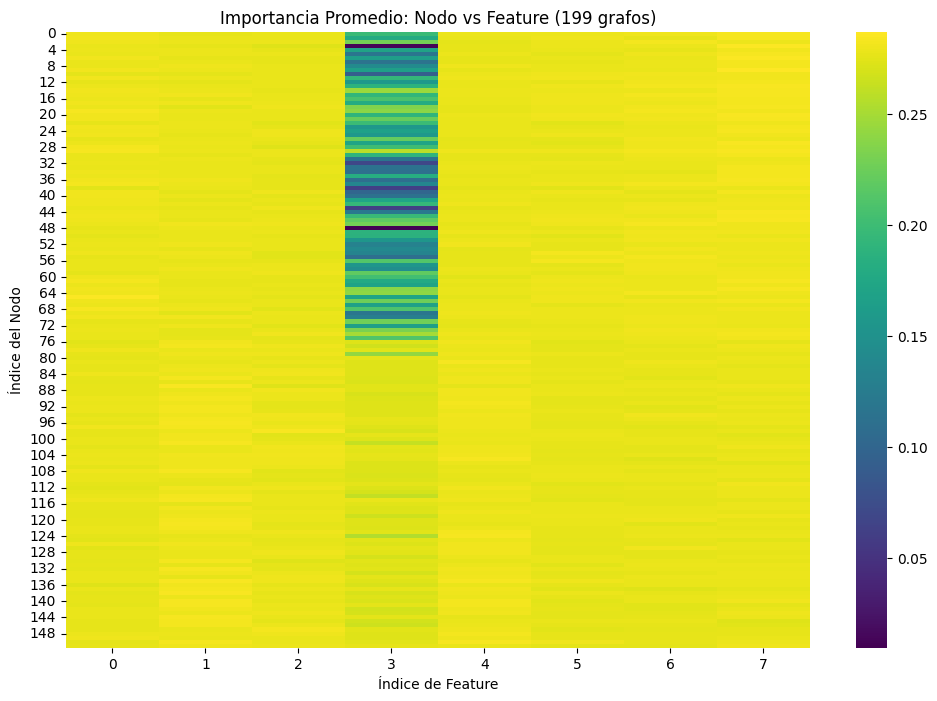

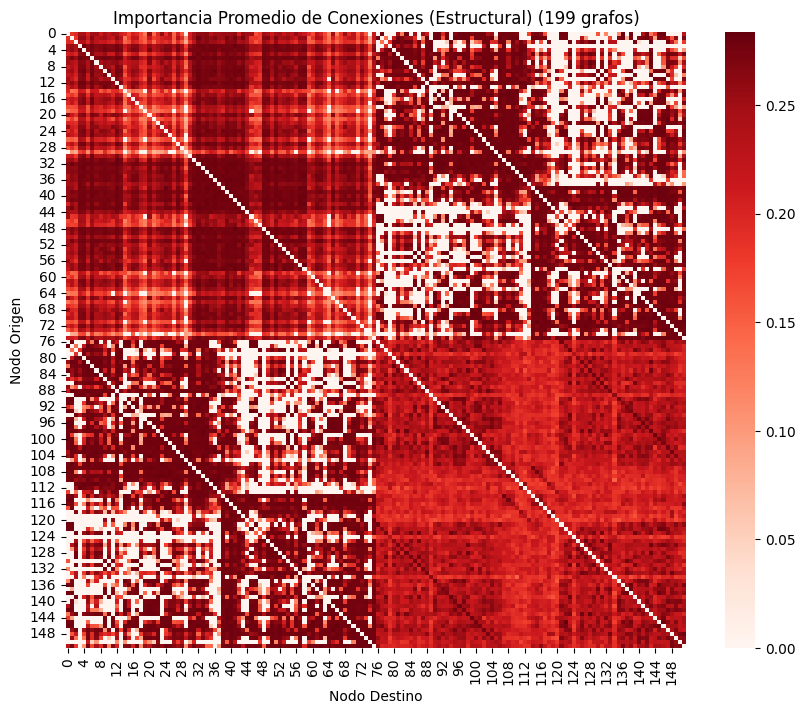

In [ ]:
avg_node_feat, avg_edges = generar_heatmaps_agregados(
    model=model,
    lista_grafos=grafos_y1,
    device=device,
    num_nodes_esperado=num_nodes_esperado
)

In [ ]:
# Guardar matriz Nodo vs Feature
df_node_feat = pd.DataFrame(avg_node_feat)
df_node_feat.to_csv("GNN/avg_node_feature.csv")
print("Guardado avg_node_feature.csv")

# Guardar matriz de Conexiones (Adyacencia)
df_edges = pd.DataFrame(avg_edges)
df_edges.to_csv("GNN/avg_edge_importance.csv")
print("Guardado avg_edge_importance.csv")

Guardado avg_node_feature.csv
Guardado avg_edge_importance.csv


## Representaciones

In [14]:
print(df_node_feat)

       Fuerza     Grado  Eficiencia  C. Intermediación  C. Cercanía        FA  \
0    0.279850  0.276156    0.277571           0.197290     0.278975  0.278856   
1    0.281278  0.277593    0.277180           0.178537     0.277871  0.279523   
2    0.279799  0.279009    0.278200           0.227707     0.275518  0.279027   
3    0.277486  0.276875    0.273543           0.012830     0.276788  0.278371   
4    0.279208  0.278741    0.276215           0.170493     0.276306  0.278108   
..        ...       ...         ...                ...          ...       ...   
147  0.276751  0.277966    0.282420           0.274880     0.279400  0.274786   
148  0.278737  0.278418    0.279654           0.273574     0.281610  0.277045   
149  0.279333  0.278088    0.278026           0.272873     0.279435  0.276702   
150  0.275674  0.281856    0.277858           0.273989     0.283186  0.279797   
151  0.276858  0.279287    0.278358           0.276084     0.278137  0.275019   

           MD   Volumen  
0

In [15]:
# -------------------------------------------------------------------
# 1. Cargar datos desde los CSV previamente guardados
# -------------------------------------------------------------------

df_node_feat = pd.read_csv("GNN/avg_node_feature.csv", index_col=0)
df_edges = pd.read_csv("GNN/avg_edge_importance.csv", index_col=0)

print("Cargado avg_node_feature.csv:", df_node_feat.shape)
print("Cargado avg_edge_importance.csv:", df_edges.shape)

avg_node_feat = df_node_feat.to_numpy(dtype=np.float32)
avg_edges = df_edges.to_numpy(dtype=np.float32)

# -------------------------------------------------------------------
# 2. Reemplazar índices de columnas por nombres de features
# -------------------------------------------------------------------

nombres_features = [
    "Fuerza", "Grado", "Eficiencia", "C. Intermediación",
    "C. Cercanía", "FA", "MD", "Volumen"
]

# Nos aseguramos de que el número de columnas coincide
if len(df_node_feat.columns) == len(nombres_features):
    df_node_feat.columns = nombres_features
else:
    print("⚠️ Advertencia: número de columnas no coincide con lista de nombres.")

Cargado avg_node_feature.csv: (152, 8)
Cargado avg_edge_importance.csv: (152, 152)


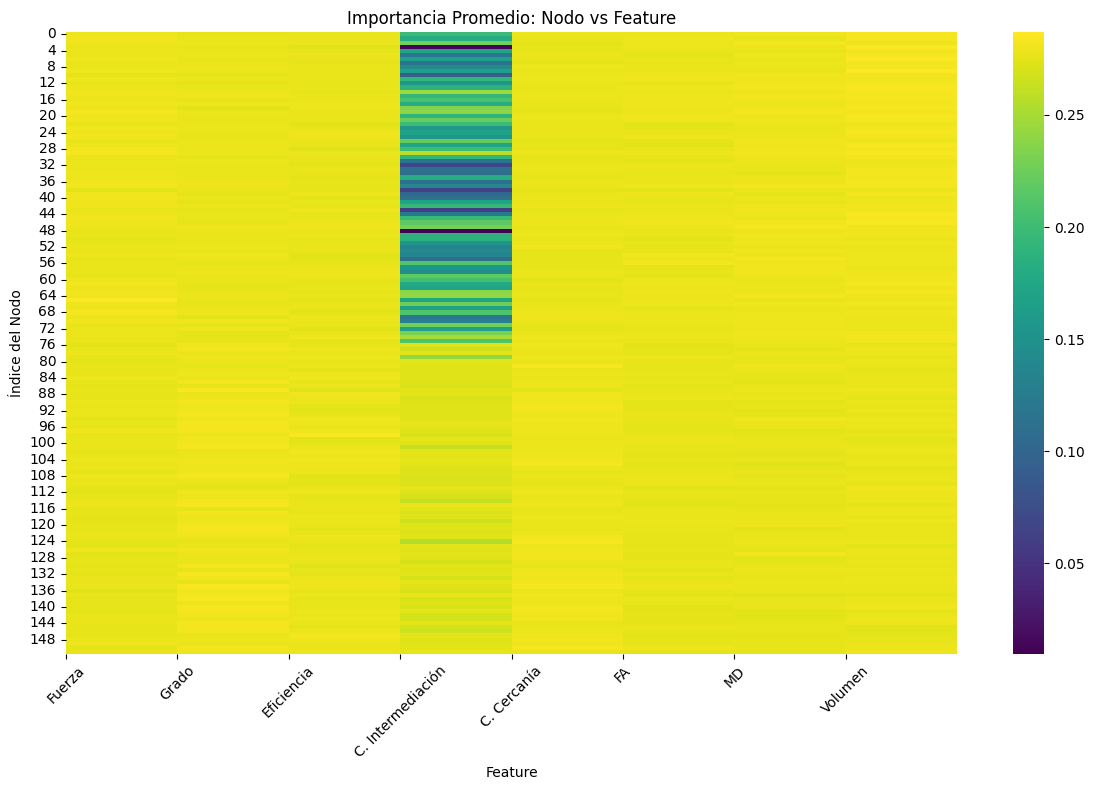

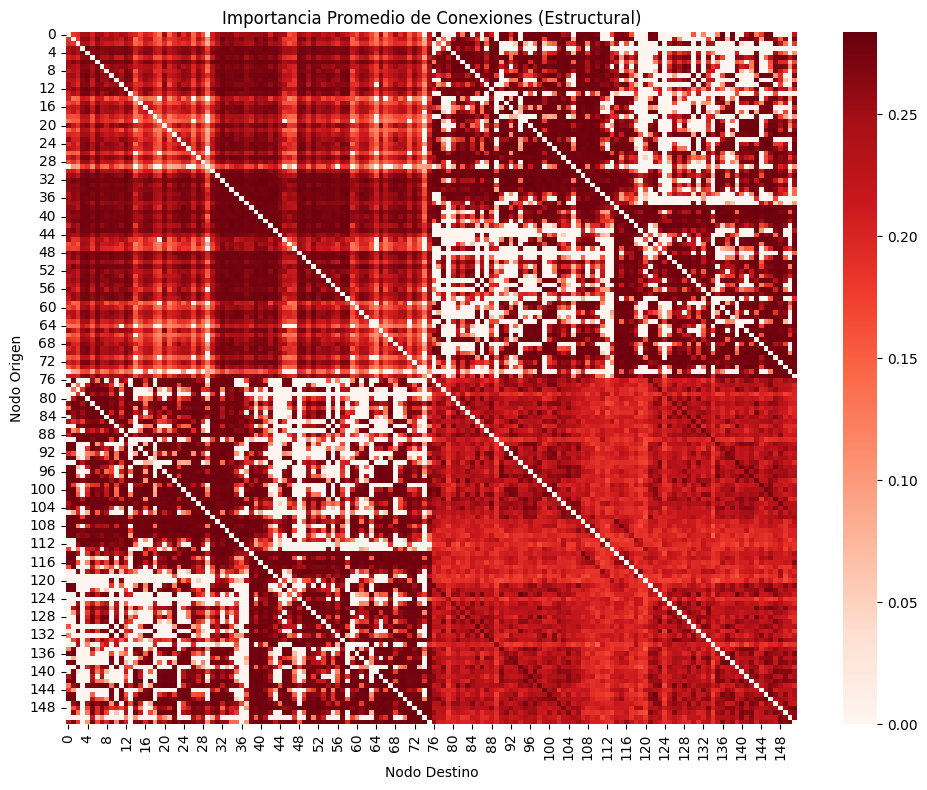

In [10]:
# -------------------------------------------------------------------
# 3. PLOTS
# -------------------------------------------------------------------

# --- PLOT 1: HEATMAP NODO vs FEATURE ---
plt.figure(figsize=(12, 8))
sns.heatmap(df_node_feat.values, cmap="viridis", annot=False)
plt.title("Importancia Promedio: Nodo vs Feature")
plt.xlabel("Feature")
plt.ylabel("Índice del Nodo")
plt.xticks(ticks=range(len(nombres_features)), labels=nombres_features, rotation=45)
plt.tight_layout()
plt.show()


# --- PLOT 2: HEATMAP CONEXIONES (Adyacencia) ---
plt.figure(figsize=(10, 8))
sns.heatmap(df_edges.values, cmap="Reds", annot=False)
plt.title("Importancia Promedio de Conexiones (Estructural)")
plt.xlabel("Nodo Destino")
plt.ylabel("Nodo Origen")
plt.tight_layout()
plt.show()

In [12]:
coordenadas_dict = {}

with open("Node_mindboggle_default.node", "r") as f:
    for idx, linea in enumerate(f):
        partes = linea.strip().split()
        # Tomamos las 3 primeras coordenadas
        coords = list(map(float, partes[:3]))
        coordenadas_dict[idx] = coords

In [21]:
def pintar_nodos(coordenadas_dict, valores, top_n=None,
                 cmap='RdYlGn', marker_size=50, marker_labels=None):
    """
    Representa los nodos en coordenadas con valores usando Nilearn view_markers.
    Si se proporciona top_n, solo muestra los nodos con los N valores más altos.

    coordenadas_dict: dict con claves 0..N y valores [x,y,z]
    valores: lista de floats del mismo tamaño que coordenadas_dict
    top_n: Si es un entero > 0, solo se visualizan los nodos con los N valores más altos.
    cmap: colormap ('RdYlGn' por defecto: Rojo=bajo, Verde=alto)
    marker_size: tamaño en píxeles para todos los marcadores
    marker_labels: lista de etiquetas (strings) para los nodos — opcional
    """

    # 1. Identificar y Filtrar los Nodos

    # Crear una lista de tuplas (valor, índice) para ordenarlas
    valor_indice = sorted([(val, i) for i, val in enumerate(valores)],
                          key=operator.itemgetter(0), reverse=True)

    # Si se pide top_n, filtramos
    if top_n is not None and top_n > 0:
        # Obtenemos los índices de los top N
        top_indices = [idx for val, idx in valor_indice[:top_n]]

        # Filtramos los datos
        valores_filtrados = [valores[i] for i in top_indices]
        coords = np.array([coordenadas_dict[i] for i in top_indices])

        if marker_labels is not None:
            marker_labels_filtradas = [marker_labels[i] for i in top_indices]
        else:
            marker_labels_filtradas = None

    else:
        # Usar todos los nodos
        valores_filtrados = valores
        coords = np.array([coordenadas_dict[i] for i in range(len(coordenadas_dict))])
        marker_labels_filtradas = marker_labels


    # 2. Mapear valores numéricos a colores

    # Usar el mínimo y máximo de los VALORES ORIGINALES (sin filtrar)
    # Esto asegura que el color de un nodo sea consistente, independientemente de si se filtra.
    # Si usáramos min(valores_filtrados), el color rojo siempre sería el valor más bajo en pantalla.
    norm = colors.Normalize(vmin=min(valores), vmax=max(valores))

    # Usar 'RdYlGn' para Rojo=bajo, Verde=alto
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    colors_mapped = mapper.to_rgba(valores_filtrados)

    # 3. Visualizar con Nilearn
    view = plotting.view_markers(marker_coords=coords,
                                 marker_color=colors_mapped,
                                 marker_size=marker_size,
                                 marker_labels=marker_labels_filtradas)

    return view


pintar_nodos(coordenadas_dict, avg_node_feat[76:,4], cmap='RdYlGn', marker_size=5, top_n=None)

Output hidden; open in https://colab.research.google.com to view.

In [20]:
def pintar_conectoma(coordenadas_dict, matriz_pesos,
                     edge_threshold=0, # MODIFICADO: Ahora puede ser un número, "auto", o "N%"
                     top_n_edges=None,      # NUEVO: Para especificar las N conexiones más fuertes
                     linewidth=3,
                     edge_cmap='RdYlGn',
                     node_color='black',
                     node_size=5,
                     vmax=None, vmin=None): # NUEVO: Control explícito de la escala de color
    """
    Representa el conectoma ajustando la escala de color y el umbral de las aristas.

    coordenadas_dict: dict con claves 0..N y valores [x,y,z].
    matriz_pesos: Matriz (numpy array, N x N) con los pesos de las conexiones.
    edge_threshold: Umbral para mostrar conexiones. Puede ser:
                    - float (valor directo)
                    - str ("N%", p. ej. "90%")
                    - "auto" (default de Nilearn: muestra la mitad de las aristas)
    top_n_edges: Si se especifica, se calcula el umbral para mostrar solo las N conexiones más fuertes.
    vmax, vmin: Valores máximo y mínimo para fijar la escala de color de las aristas.
                Si no se especifican, se usan los valores min/max de la matriz.
    """
    # 1. Extraer coordenadas
    coords = np.array([coordenadas_dict[i] for i in range(len(coordenadas_dict))])

    # 2. Manejo del umbral (Top N)
    # Si se pide el top_n_edges, calculamos el umbral como porcentaje
    if top_n_edges is not None and isinstance(top_n_edges, int):
        # Número total de aristas posibles (N*(N-1)/2 para matriz simétrica)
        # Aquí usamos N*N para simplificar y dejar que Nilearn maneje la simetría
        N_nodes = len(coordenadas_dict)
        total_possible_edges = (N_nodes * N_nodes) - N_nodes # Excluye la diagonal

        # El porcentaje a MOSTRAR es N / Total
        percentage_to_show = (top_n_edges / total_possible_edges) * 100

        # Nilearn usa el umbral como el porcentaje a OCULTAR.
        # Por lo tanto, el umbral es 100 - (porcentaje a mostrar).
        threshold_to_hide = 100 - percentage_to_show

        # Establecemos el edge_threshold como una cadena de porcentaje (p. ej., "95%")
        edge_threshold = f"{threshold_to_hide:.2f}%"
        print(f"Calculando umbral para mostrar las {top_n_edges} aristas más fuertes. Umbral establecido en {edge_threshold}")

    # 4. Llamar a la función view_connectome de Nilearn
    view = plotting.view_connectome(
        matriz_pesos,
        node_coords=coords,
        edge_threshold=edge_threshold, # Utiliza el umbral calculado o pasado
        linewidth=linewidth,
        edge_cmap=edge_cmap,
        node_color=node_color,
        node_size=node_size,
        symmetric_cmap=False
    )

    return view

pintar_conectoma(coordenadas_dict, avg_edges[76:,76:], top_n_edges=100)

Output hidden; open in https://colab.research.google.com to view.